#Entregable 1: BMW Data Engineering

##Importación de datos mediante 'Secrets'

In [1]:
from google.colab import userdata
import json
from google.oauth2 import service_account
from googleapiclient.discovery import build

key_json = userdata.get('GDRIVE_SERVICE_KEY')
key_dict = json.loads(key_json)

SCOPES = ['https://www.googleapis.com/auth/drive']
creds = service_account.Credentials.from_service_account_info(key_dict, scopes=SCOPES)

service = build('drive', 'v3', credentials = creds)

In [2]:
def list_all_files_recursive(service, folder_id, parent_path=""):
    results = service.files().list(
        q=f"'{folder_id}' in parents and trashed = false",
        fields="files(id, name, mimeType)"
    ).execute()

    files = results.get('files', [])

    all_files = []

    for item in files:
        name = item['name']
        file_id = item['id']
        mime = item['mimeType']

        # Google Drive folder mimeType
        if mime == 'application/vnd.google-apps.folder':
            # Recurse into subfolder
            all_files.extend(
                list_all_files_recursive(
                    service,
                    file_id,
                    parent_path + name + "/"
                )
            )
        else:
            all_files.append({
                "path": parent_path + name,
                "id": file_id
            })

    return all_files


In [3]:
import io
import pandas as pd
from googleapiclient.http import MediaIoBaseDownload

def read_csv_from_drive(service, file_id):
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()

    fh.seek(0)
    return pd.read_csv(fh)


In [4]:
df = read_csv_from_drive(service, "1jMHCscOfdzugZY45smuSO9bUicSN94ME")
df.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [5]:
import os

LOCAL_DIR = "drive_files"
os.makedirs(LOCAL_DIR, exist_ok = True)

##1. Importación de librerías, primera visualización de dataframe, comprobación de duplicados, eliminación de columnas y ajuste formato columnas con fecha

In [6]:
# IMPORTAMOS LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler

In [7]:
df

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,BMW,218 Gran Tourer,39743.0,110.0,NaN,diesel,black,NaN,False,True,False,NaN,False,False,True,False,14600.0,2018-08-01
4839,BMW,218 Active Tourer,49832.0,100.0,2015-06-01,diesel,grey,NaN,False,True,False,NaN,False,False,True,True,17500.0,2018-08-01
4840,BMW,218 Gran Tourer,19633.0,110.0,2015-10-01,diesel,grey,van,False,True,False,NaN,False,False,True,True,17000.0,2018-09-01
4841,BMW,218 Active Tourer,27920.0,110.0,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,22700.0,2018-09-01


In [8]:
df[df.duplicated(keep="first")]

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta


###1.1. Eliminación de columnas por no tener variedad ('marca') o mayoría de nulos ('asientos_traseros_plegables')

In [9]:
df['marca'].value_counts(dropna = False)

,count
marca,
BMW,3873
NaN,970


Eliminamos la columna 'marca' dado que sólo tiene como valor BMW y es un dataset de BMW, por lo que no aportaría información

In [10]:
del(df['marca'])

In [11]:
df['asientos_traseros_plegables'].value_counts(dropna=False)

,count
asientos_traseros_plegables,
NaN,3391
False,1150
True,302


In [12]:
df['asientos_traseros_plegables'].isnull().sum()/df.shape[0]*100

np.float64(70.01858352260996)

<Axes: xlabel='asientos_traseros_plegables', ylabel='precio'>

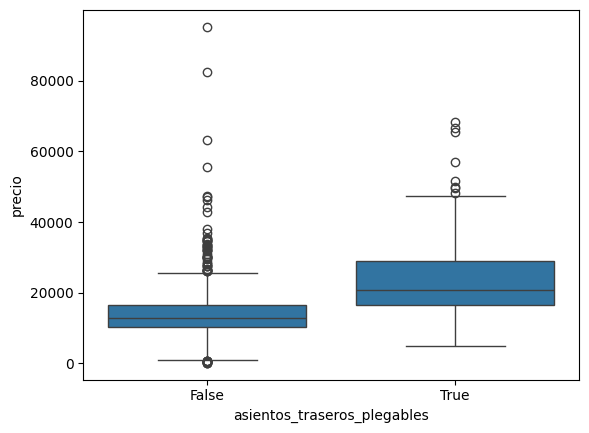

In [13]:
sns.boxplot(x=df['asientos_traseros_plegables'], y=df['precio'])

In [14]:
df['asientos_traseros_plegables'] = df['asientos_traseros_plegables'].fillna(-1)

In [15]:
df['asientos_traseros_plegables'] = df['asientos_traseros_plegables'].astype(int)

In [16]:
df.groupby('asientos_traseros_plegables')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
asientos_traseros_plegables,,,,,,,,
-1,3388.0,15797.756789,9318.325532,100.0,10800.0,14300.0,18600.0,178500.0
0,1147.0,13903.487358,7271.833949,200.0,10200.0,13000.0,16400.0,95200.0
1,302.0,23539.403974,10694.821471,4900.0,16400.0,20700.0,29075.0,68300.0


Borramos la columna 'asientos_traseros_plegables' dado que la gran mayoría de datos (70%) son nulos y no aporta gran información (en total son 302 valores True, por lo que no se puede concluir info o que sean representativos)

In [17]:
del(df['asientos_traseros_plegables'])

###1.2. Fechas a formato datetime

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   modelo                4840 non-null   object 
 1   km                    4841 non-null   float64
 2   potencia              4842 non-null   float64
 3   fecha_registro        2420 non-null   object 
 4   tipo_gasolina         4838 non-null   object 
 5   color                 4398 non-null   object 
 6   tipo_coche            3383 non-null   object 
 7   volante_regulable     4839 non-null   object 
 8   aire_acondicionado    4357 non-null   object 
 9   camara_trasera        4841 non-null   object 
 10  elevalunas_electrico  4841 non-null   object 
 11  bluetooth             4115 non-null   object 
 12  gps                   4843 non-null   bool   
 13  alerta_lim_velocidad  4115 non-null   object 
 14  precio                4837 non-null   float64
 15  fecha_venta          

In [19]:
for i in ['fecha_registro', 'fecha_venta']:
  df[i] = pd.to_datetime(df[i])

##2. Gestión de nulos

###2.1 Borrado de filas de columnas con pocos nulos sin moda clara
Borramos las filas de nulos en columnas con pocos nulos sin moda clara como "modelo", "km", "volante_regulable", "elevalunas_electrico", "fecha_venta", "precio" (variable target que no podemos modificar)

El tipo de combustible y camara trasera tienen modas claras

In [20]:
df2 = df.copy()

In [21]:
df2.isnull().sum()

,0
modelo,3
km,2
potencia,1
fecha_registro,2423
tipo_gasolina,5
color,445
tipo_coche,1460
volante_regulable,4
aire_acondicionado,486
camara_trasera,2


In [22]:
df2.dropna(subset = ['fecha_venta'], inplace = True) #Eliminamos la fila con valor nulo de esta columna

In [23]:
df2.dropna(subset = ['precio'], inplace = True) #Al ser el Target no podemos modificarlo y se eliminan las filas con dato nulo

In [24]:
df2['elevalunas_electrico'].value_counts(dropna = False)

,count
elevalunas_electrico,
False,2608
True,2226
NaN,2


In [25]:
df2.dropna(subset = ['elevalunas_electrico'], inplace = True)

In [26]:
df2['volante_regulable'].value_counts(dropna = False)

,count
volante_regulable,
True,2655
False,2175
NaN,4


In [27]:
df2.dropna(subset = ['volante_regulable'], inplace = True)

In [28]:
df2.loc[df2['km'].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
459,520,NaN,135.0,2012-12-01,diesel,black,NaN,True,True,True,True,True,True,True,20300.0,2018-02-01
4811,X3,NaN,190.0,NaT,diesel,blue,van,True,True,True,True,False,True,True,19500.0,2018-07-01


<Axes: xlabel='km', ylabel='precio'>

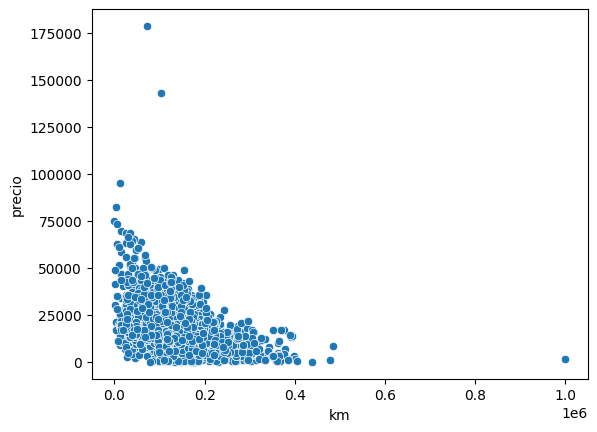

In [29]:
sns.scatterplot(x=df2['km'], y = df2['precio'])

In [30]:
df2.dropna(subset = ['km'], inplace = True) # Al haber 2 filas con valor nulo, decidimos eliminarlas dado que el km de un coche puede afectar al precio de forma sensible

In [31]:
df2.loc[df2['modelo'].isnull()] #Advertimos que son 3 filas con valor nulo y dos de ellas tampoco tienen valor en 'tipo_coche' ni 'fecha_registro', por lo que se decide eliminar estas filas

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
173,NaN,146338.0,105.0,NaT,diesel,black,NaN,False,True,False,False,NaN,True,NaN,13300.0,2018-08-01
4766,NaN,115566.0,105.0,2014-01-01,diesel,silver,suv,False,True,False,True,False,True,False,14900.0,2018-09-01
4802,NaN,118640.0,110.0,NaT,diesel,white,NaN,False,False,False,False,False,False,False,800.0,2018-03-01


In [32]:
df2.dropna(subset = ['modelo'], inplace = True)

###2.2. Tratado de las demás columnas con nulos

####2.2.1. Para el valor nulo de la potencia, al tratarse de una fila con un único nulo, procedemos a reemplazar el nulo con la media de potencia del modelo en cuestión (525)
También se detecta un coche con potencia 0 y se trata como nulo, asignando la media de potencia de su modelo "X1"

In [33]:
df3 = df2.copy()

In [34]:
df3.isnull().sum()

,0
modelo,0
km,0
potencia,1
fecha_registro,2412
tipo_gasolina,5
color,443
tipo_coche,1451
volante_regulable,0
aire_acondicionado,483
camara_trasera,2


In [35]:
df3.loc[df2['potencia'].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
181,525,106054.0,NaN,2014-05-01,diesel,black,estate,False,True,False,False,False,True,True,18700.0,2018-03-01


<Axes: xlabel='potencia', ylabel='precio'>

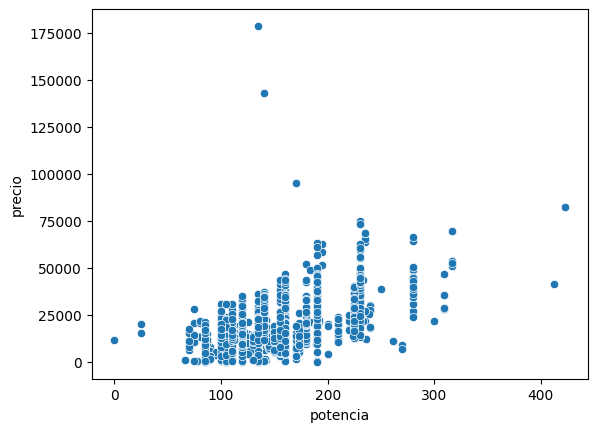

In [36]:
sns.scatterplot(x=df3['potencia'], y=df3['precio'])

In [37]:
df3['potencia'].loc[df3['modelo'] == "525"].mean() #Buscamos la media de potencia del modelo 525 para rellenar el valor nulo

np.float64(150.91758241758242)

In [38]:
df3['potencia'] = df3['potencia'].fillna(df3['potencia'].loc[df3['modelo'] == "525"].mean())

In [39]:
df3['potencia'].loc[df3['modelo'] == "X1"].mean()

np.float64(109.95255474452554)

In [40]:
df3.loc[df3['potencia']<70]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
1796,i3,152328.0,25.0,NaT,hybrid_petrol,black,NaN,False,True,False,False,False,True,NaN,20300.0,2018-04-01
1925,i3,152470.0,25.0,NaT,hybrid_petrol,black,hatchback,False,True,False,False,False,True,True,15500.0,2018-03-01
2390,318,170529.0,66.0,NaT,diesel,silver,hatchback,False,False,True,False,False,False,False,1000.0,2018-08-01
2771,316,146951.0,66.0,1990-03-01,petrol,white,sedan,False,False,False,False,False,False,False,1300.0,2018-04-01
3765,X1,81770.0,0.0,2014-10-01,diesel,white,suv,False,False,False,False,False,False,NaN,11700.0,2018-03-01


In [41]:
df3['potencia'].loc[df3['potencia']==0] = df3['potencia'].loc[df3['modelo'] == "X1"].mean()

/tmp/ipython-input-1343699944.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df3['potencia'].loc[df3['potencia']==0] = df3['potencia'].loc[df3['modelo'] == "X1"].mean()
/tmp/ipython-input-1343699944.py:1: SettingWithCopyWarning: 
A valu

####2.2.2. Para el "tipo gasolina" se aprecia una clara moda "diesel", por lo que los NaN de esta columna se introducirán como la moda (además se corrige la categoría diesel repetida)

In [42]:
df3['tipo_gasolina'].value_counts()

,count
tipo_gasolina,
diesel,4613
petrol,191
hybrid_petrol,8
Diesel,5
electro,3


In [43]:
df3.loc[df3['tipo_gasolina'].isnull()] #los modelos de las filas con nulos no contradicen que se puedan rellenar con Diésel

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
82,420,54993.0,135.0,NaT,NaN,black,NaN,False,False,False,False,False,False,False,18400.0,2018-03-01
185,320,186697.0,135.0,2012-11-01,NaN,white,estate,False,False,False,False,False,False,True,2400.0,2018-04-01
444,318,111622.0,100.0,2013-01-01,NaN,black,estate,True,True,False,False,False,True,True,15400.0,2018-02-01
480,318,170350.0,105.0,NaT,NaN,white,NaN,False,True,False,False,False,True,False,10200.0,2018-02-01
630,318,147558.0,105.0,2014-11-01,NaN,white,estate,False,NaN,False,False,False,False,True,100.0,2018-03-01


In [44]:
df3['tipo_gasolina'] = df3['tipo_gasolina'].fillna("diesel")

In [45]:
df3.loc[df3['tipo_gasolina']=='Diesel', "tipo_gasolina"] = "diesel"

In [46]:
df3['tipo_gasolina'].value_counts()

,count
tipo_gasolina,
diesel,4623
petrol,191
hybrid_petrol,8
electro,3


####2.2.3. Para la columna "camara_trasera" también se aprecia la moda "False", por lo que se decide añadir este valor en los NaN.

In [47]:
df3['camara_trasera'].value_counts(dropna = False)

,count
camara_trasera,
False,3853
True,970
NaN,2


In [48]:
df3['camara_trasera'] = df3['camara_trasera'].fillna(False)

/tmp/ipython-input-1571836722.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3['camara_trasera'] = df3['camara_trasera'].fillna(False)


####2.2.4. En la columna "color" se decide añadir una categoría 'No_color' para los valores nulos (no hay moda clara y son 443 valores)

In [49]:
df3.isnull().sum()

,0
modelo,0
km,0
potencia,0
fecha_registro,2412
tipo_gasolina,0
color,443
tipo_coche,1451
volante_regulable,0
aire_acondicionado,483
camara_trasera,0


In [50]:
df3['color'].value_counts(dropna = False)

,count
color,
black,1493
grey,1067
blue,643
white,483
NaN,443
brown,302
silver,290
red,47
beige,37


In [51]:
df3['color'] =  df3['color'].fillna("Other_color")

####2.2.5. Columna 'Tipo coche', mismo procedimiento que columna "color"

In [52]:
df3['tipo_coche'].value_counts(dropna=False)

,count
tipo_coche,
NaN,1451
estate,1103
sedan,821
suv,754
hatchback,488
subcompact,77
coupe,73
convertible,30
van,28


In [53]:
df3['tipo_coche'] =  df3['tipo_coche'].fillna("Otro_tipo")

####2.2.6. Columnas con >10% nulos ['aire_acondicinado', 'bluetooth', 'alerta_lim_velocidad'] se decide añadir una columna de valor missing (boolean de si el valor era nulo o no) para facilitar el análisis y se rellena con valor 'False'

In [54]:
df3['aire_acondicionado'].value_counts(dropna = False, normalize = True)

,proportion
aire_acondicionado,
True,0.715855
False,0.184041
NaN,0.100104


In [55]:
df3['bluetooth'].value_counts(dropna = False, normalize = True)

,proportion
bluetooth,
False,0.643938
True,0.205389
NaN,0.150674


In [56]:
df3['alerta_lim_velocidad'].value_counts(dropna = False, normalize = True)

,proportion
alerta_lim_velocidad,
True,0.462383
False,0.387150
NaN,0.150466


In [57]:
for col in ['aire_acondicionado', 'bluetooth', 'alerta_lim_velocidad']:
  df3[col + '_missing'] = df3[col].isna().astype(bool)
  df3[col] = df3[col].fillna(False)

/tmp/ipython-input-3757700093.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3[col] = df3[col].fillna(False)
/tmp/ipython-input-3757700093.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3[col] = df3[col].fillna(False)
/tmp/ipython-input-3757700093.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3[col] = df3[col].fillna

In [58]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4825 entries, 0 to 4842
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   modelo                        4825 non-null   object        
 1   km                            4825 non-null   float64       
 2   potencia                      4825 non-null   float64       
 3   fecha_registro                2413 non-null   datetime64[ns]
 4   tipo_gasolina                 4825 non-null   object        
 5   color                         4825 non-null   object        
 6   tipo_coche                    4825 non-null   object        
 7   volante_regulable             4825 non-null   object        
 8   aire_acondicionado            4825 non-null   bool          
 9   camara_trasera                4825 non-null   bool          
 10  elevalunas_electrico          4825 non-null   object        
 11  bluetooth                     4825 

####2.2.7. Columna "fecha_registro": se decide poner una fecha muy pronta (01-01-1900) fuera del rango de fechas del registro y una columna de valor missing

In [59]:
df3['fecha_registro'].dt.year.value_counts()

,count
fecha_registro,
2013.0,755
2014.0,634
2012.0,433
2015.0,162
2011.0,117
2010.0,51
2016.0,46
2008.0,42
2009.0,39


<Axes: >

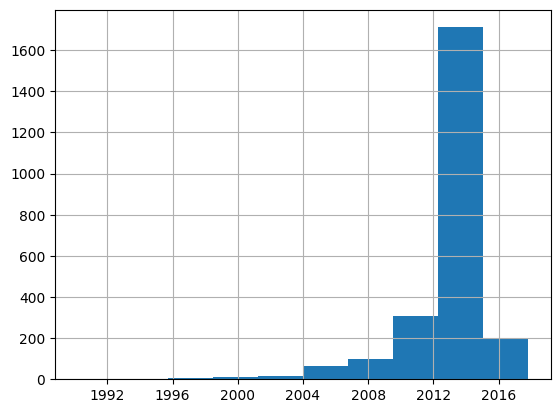

In [60]:
df3['fecha_registro'].hist()

In [61]:
df3['fecha_registro' + '_missing'] = df3['fecha_registro'].isna().astype(bool)

In [62]:
df3.groupby('fecha_registro_missing')['precio'].describe() #Aquí observamos que los valores con y sin fecha de registro tienen valores similares

,count,mean,std,min,25%,50%,75%,max
fecha_registro_missing,,,,,,,,
False,2413.0,16001.160381,9610.514055,100.0,11100.0,14300.0,19000.0,178500.0
True,2412.0,15667.951907,8812.876892,100.0,10700.0,14000.0,18300.0,95200.0


In [63]:
df3['fecha_registro'] = df3['fecha_registro'].fillna(pd.Timestamp('1900-01-01')) #Rellenamos los valores nulos en registro con una fecha fuera del rango de fechas de registro

In [64]:
df3.head(10)

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing
0,118,140411.0,100.0,2012-02-01,diesel,black,Otro_tipo,True,True,False,True,False,True,False,11300.0,2018-01-01,False,True,True,False
1,M4,13929.0,317.0,1900-01-01,petrol,grey,convertible,True,True,False,False,True,True,True,69700.0,2018-02-01,False,False,False,True
2,320,183297.0,120.0,2012-04-01,diesel,white,Otro_tipo,False,False,False,True,False,True,False,10200.0,2018-02-01,False,False,False,False
3,420,128035.0,135.0,1900-01-01,diesel,red,convertible,True,True,False,True,True,True,False,25100.0,2018-02-01,False,False,True,True
4,425,97097.0,160.0,1900-01-01,diesel,silver,Otro_tipo,True,True,False,False,True,True,True,33400.0,2018-04-01,False,False,False,True
5,335,152352.0,225.0,2011-05-01,petrol,black,Otro_tipo,True,True,False,True,True,True,True,17100.0,2018-02-01,False,False,False,False
6,325,205219.0,145.0,1900-01-01,diesel,grey,convertible,True,True,False,True,True,True,True,12400.0,2018-02-01,False,False,False,True
7,118,115560.0,105.0,2009-08-01,petrol,white,convertible,True,True,False,False,True,True,False,6100.0,2018-02-01,False,False,False,False
8,Z4,123886.0,125.0,1900-01-01,petrol,black,convertible,True,False,False,False,False,True,False,6200.0,2018-03-01,False,True,False,True
9,320,139541.0,135.0,1900-01-01,diesel,white,convertible,False,False,False,True,False,True,False,17300.0,2018-03-01,False,False,False,True


In [65]:
df3.isnull().sum()

,0
modelo,0
km,0
potencia,0
fecha_registro,0
tipo_gasolina,0
color,0
tipo_coche,0
volante_regulable,0
aire_acondicionado,0
camara_trasera,0


##3. Análisis univariable

###3.1. Columnas de fechas a mes y año (todos los días son 1) y adición de columna meses_registro_a_venta (diferencia de meses entre registro y venta, incluyendo su missing)


In [66]:
df4 = df3.copy()

In [67]:
df4['meses_registro_a_venta']=(
    (df4['fecha_venta'].dt.year-df4['fecha_registro'].dt.year)*12
    +df4['fecha_venta'].dt.month-df4['fecha_registro'].dt.month)
df4['meses_registro_a_venta'+'_missing']=df4['fecha_registro_missing']

In [68]:
for col in ['fecha_registro', 'fecha_venta']:
  df4[col + '_month'] = df4[col].dt.month
  df4[col + '_year'] = df4[col].dt.year

  del(df4[col])


In [69]:
df4.head(10)

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,...,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year
0,118,140411.0,100.0,diesel,black,Otro_tipo,True,True,False,True,...,False,True,True,False,71,False,2,2012,1,2018
1,M4,13929.0,317.0,petrol,grey,convertible,True,True,False,False,...,False,False,False,True,1417,True,1,1900,2,2018
2,320,183297.0,120.0,diesel,white,Otro_tipo,False,False,False,True,...,False,False,False,False,70,False,4,2012,2,2018
3,420,128035.0,135.0,diesel,red,convertible,True,True,False,True,...,False,False,True,True,1417,True,1,1900,2,2018
4,425,97097.0,160.0,diesel,silver,Otro_tipo,True,True,False,False,...,False,False,False,True,1419,True,1,1900,4,2018
5,335,152352.0,225.0,petrol,black,Otro_tipo,True,True,False,True,...,False,False,False,False,81,False,5,2011,2,2018
6,325,205219.0,145.0,diesel,grey,convertible,True,True,False,True,...,False,False,False,True,1417,True,1,1900,2,2018
7,118,115560.0,105.0,petrol,white,convertible,True,True,False,False,...,False,False,False,False,102,False,8,2009,2,2018
8,Z4,123886.0,125.0,petrol,black,convertible,True,False,False,False,...,False,True,False,True,1418,True,1,1900,3,2018
9,320,139541.0,135.0,diesel,white,convertible,False,False,False,True,...,False,False,False,True,1418,True,1,1900,3,2018


###3.2. Análisis univariable por tipo

* 'km' tiene 1 valor negativo y un valor de 1 millón (outliers)
* 'modelo' tiene info de categorías de coche según el modelo  
* 'gps' tiene sólo 328 valores False, poca info en esta columna
*   'fecha_venta' tiene valores entre enero y septiembre de 2018, a expeción de 4 filas
* 'fecha_registro' tiene la mayor parte de los valores no nulos entre 2012 y 2014
* 'tipo_gasolina' tiene únicamente 11 valores que no son ni diésel ni gasolina. Se decide eliminar estas 11 filas y sustituir la columna por una llamada 'is_petrol' con valor 1 si el coche es gasolina y 0 si es diesel.




In [70]:
for col in ['volante_regulable', 'elevalunas_electrico']:
  df4[col] = df4[col].astype(bool)

In [71]:
for i in df4:
  print(i,df4[i].dtype.kind)

modelo O
km f
potencia f
tipo_gasolina O
color O
tipo_coche O
volante_regulable b
aire_acondicionado b
camara_trasera b
elevalunas_electrico b
bluetooth b
gps b
alerta_lim_velocidad b
precio f
aire_acondicionado_missing b
bluetooth_missing b
alerta_lim_velocidad_missing b
fecha_registro_missing b
meses_registro_a_venta i
meses_registro_a_venta_missing b
fecha_registro_month i
fecha_registro_year i
fecha_venta_month i
fecha_venta_year i


modelo 
 modelo
320                  748
520                  631
318                  565
X3                   437
116                  358
                    ... 
216                    1
220 Active Tourer      1
 Active Tourer         1
225 Active Tourer      1
214 Gran Tourer        1
Name: count, Length: 76, dtype: int64 

[[<Axes: title={'center': 'km'}>]]
[[<Axes: title={'center': 'potencia'}>]]
tipo_gasolina 
 tipo_gasolina
diesel           4623
petrol            191
hybrid_petrol       8
electro             3
Name: count, dtype: int64 

color 
 color
black          1493
grey           1067
blue            643
white           483
Other_color     443
brown           302
silver          290
red              47
beige            37
green            14
orange            6
Name: count, dtype: int64 

tipo_coche 
 tipo_coche
Otro_tipo      1451
estate         1103
sedan           821
suv             754
hatchback       488
subcompact       77
coupe            73
convertible      30
v

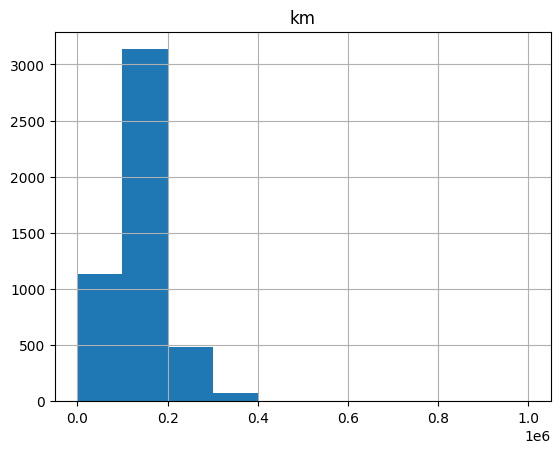

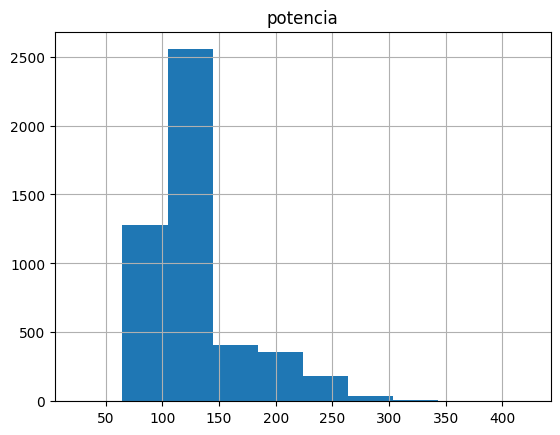

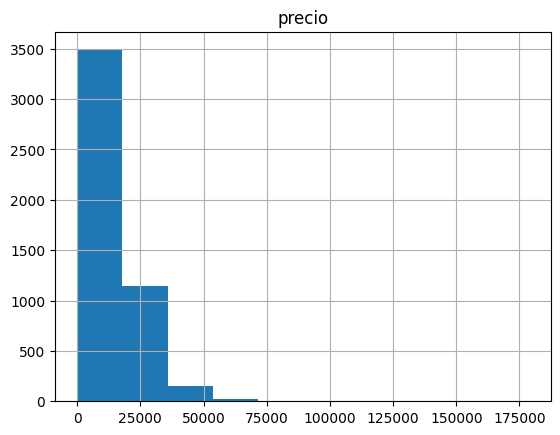

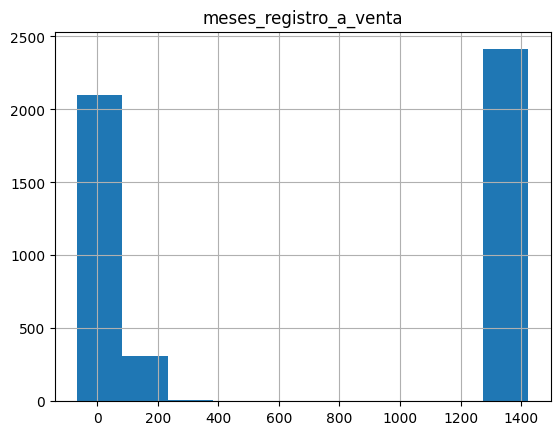

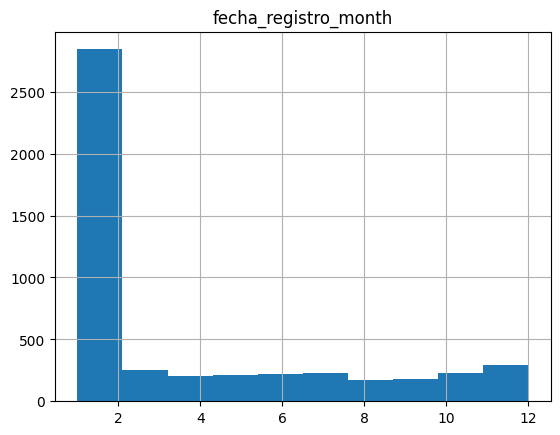

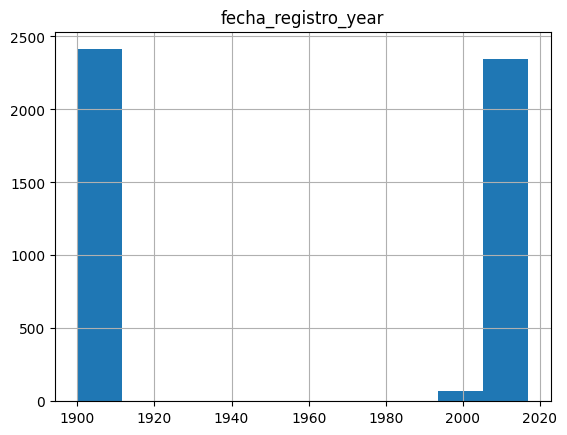

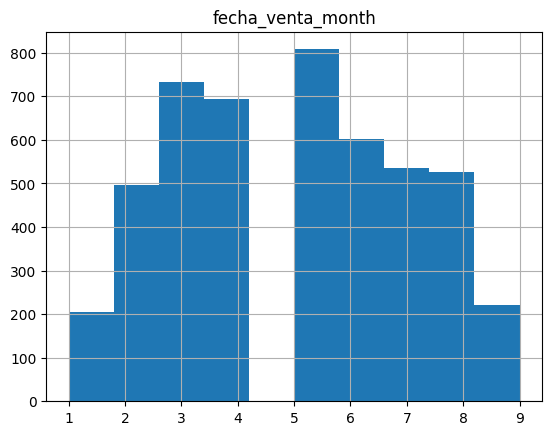

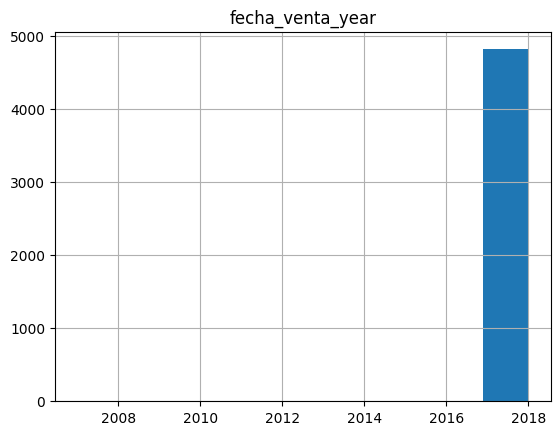

In [72]:
for i in df4:
  if (df4[i].dtype.kind == "O") or(df4[i].dtype.kind == "b"):
    print(i,'\n', df4[i].value_counts(), '\n')
  elif (df4[i].dtype.kind=="f") or (df4[i].dtype.kind=="i"):
    print(df4.hist(i))

<Axes: >

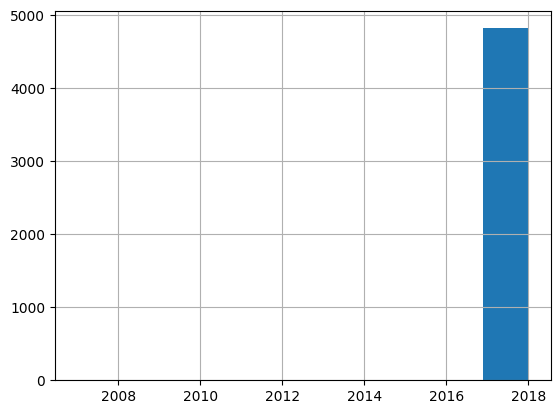

In [73]:
df4['fecha_venta_year'].hist()

In [74]:
df4.drop(df4.loc[df4['fecha_venta_year']<2018].index, axis=0,inplace=True)

In [75]:
df4['km'].describe()

,km
count,4.821000e+03
mean,1.408669e+05
std,6.016146e+04
min,-6.400000e+01
25%,1.027580e+05
50%,1.409040e+05
75%,1.751720e+05
max,1.000376e+06


<Axes: xlabel='km'>

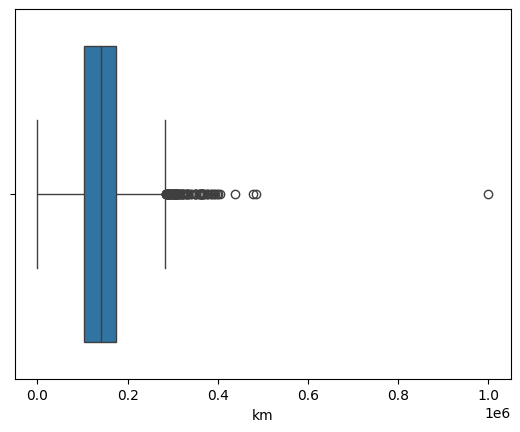

In [76]:
sns.boxplot(x=df4['km'])

In [77]:
df4.loc[df4['km']<1000]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,...,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year
2409,420 Gran Coupé,476.0,120.0,diesel,blue,hatchback,True,True,False,False,...,False,False,False,True,1423,True,1,1900,8,2018
2938,640 Gran Coupé,-64.0,230.0,diesel,black,sedan,True,True,False,False,...,False,False,False,True,1419,True,1,1900,4,2018
3935,X5,706.0,155.0,diesel,black,suv,True,True,False,True,...,False,False,True,False,7,False,7,2017,2,2018
4372,X5,612.0,183.0,diesel,black,suv,True,True,False,False,...,False,False,False,False,20,False,10,2016,6,2018


In [78]:
df4.drop(df4.loc[df4['km']<0].index, axis=0, inplace=True)

In [79]:
df4.loc[df4['km']<0]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,...,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year


In [80]:
df4.drop(df4.loc[df4['km']>800000].index, axis=0, inplace=True)

In [81]:
df4.loc[df4['km']>800000]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,...,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year


In [82]:
df4['tipo_gasolina'].value_counts()

,count
tipo_gasolina,
diesel,4617
petrol,191
hybrid_petrol,8
electro,3


In [83]:
#Borramos los 11 coches que no son ni petrol ni diesel
df4.drop(df4.loc[(df4['tipo_gasolina']=='hybrid_petrol')|(df4['tipo_gasolina']=='electro')].index, axis=0, inplace=True)

In [84]:
df4['is_petrol'] = df4['tipo_gasolina'].str.contains('petrol')

In [85]:
#Borramos la columna 'tipo_gasolina' ya que su info está en 'is_petrol'
del(df4['tipo_gasolina'])

In [86]:
df4.head()

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,...,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year,is_petrol
0,118,140411.0,100.0,black,Otro_tipo,True,True,False,True,False,...,True,True,False,71,False,2,2012,1,2018,False
1,M4,13929.0,317.0,grey,convertible,True,True,False,False,True,...,False,False,True,1417,True,1,1900,2,2018,True
2,320,183297.0,120.0,white,Otro_tipo,False,False,False,True,False,...,False,False,False,70,False,4,2012,2,2018,False
3,420,128035.0,135.0,red,convertible,True,True,False,True,True,...,False,True,True,1417,True,1,1900,2,2018,False
4,425,97097.0,160.0,silver,Otro_tipo,True,True,False,False,True,...,False,False,True,1419,True,1,1900,4,2018,False


###3.3. Modelo: al revisar el significado de los números y letras en los modelos de BMW, se decide dividir el modelo en columnas: Series, Model_Class (la cual estudiaremos su variabilidad e info que aporta: X1/X3/X5... gran/Active, etc)

In [87]:
pd.set_option('display.max_rows', 76)

In [88]:
df4['modelo'].value_counts()

,count
modelo,
320,746
520,631
318,565
X3,437
116,358
X1,274
316,233
X5,229
525,183


In [89]:
df5 = df4.copy()

In [90]:
import re

def get_series(model):
    model = model.strip()

    if model.startswith("X"):
        return "X"

    if model.startswith("Z"):
        return "Z"

    if model.startswith("i"):
        return "i"

    if model.startswith("M"):
        return "M"

    match = re.match(r"(\d)", model)
    if match:
        return f"{match.group(1)} Series"

    return "Unknown"


In [91]:
df5['Series']=df5['modelo'].apply(get_series)

In [92]:
df5.loc[df5['modelo']=="ActiveHybrid 5",'Series']="5 Series"

In [93]:
df5.loc[df5['modelo']=="M135", 'Series']="1 Series" #Se ha comprobado que este modelo es de 1 Series y no M

In [94]:
df5.loc[df5['modelo']=="M235", 'Series']="2 Series" #Se ha comprobado que este modelo es de 2 Series y no M

In [95]:
df5.loc[df5['modelo']=="Active Tourer"]

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,...,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year,is_petrol,Series


In [96]:
df5['Series'].value_counts()

,count
Series,
3 Series,1787
5 Series,1135
X,1057
1 Series,563
4 Series,102
7 Series,54
2 Series,52
6 Series,29
M,22


In [97]:
df5.loc[df5['Series']=='Unknown','Series'] = '2 Series' #Al ser Tourer es 2 Series (el filtro con 'Active Tourer' en modelo no funcionaba)

In [98]:
df5['is_gran'] = df5['modelo'].str.contains('Gran')

In [99]:
df5['is_gran'].sum()

np.int64(306)

In [100]:
 #La categoría 'active' sólo tiene 19 coches, no es info representativa
df5['modelo'].str.contains('Active').sum()

np.int64(19)

In [101]:
df5.loc[df5['Series']=="X"].groupby('modelo')['precio'].describe() #El Model_Class que muestra variabilidad respecto al target son las X Series, por lo que se hará una columna que marca el modelo X en cuestión (X1,X3,X5,X_Other)

,count,mean,std,min,25%,50%,75%,max
modelo,,,,,,,,
X1,274.0,12691.970803,3512.042253,600.0,11100.0,12900.0,14600.0,25800.0
X3,437.0,18172.768879,9569.922055,100.0,15100.0,17600.0,21200.0,178500.0
X4,46.0,33895.652174,17116.826764,19000.0,29275.0,31800.0,34575.0,142800.0
X5,229.0,30406.986900,11747.199894,3000.0,20300.0,33600.0,39300.0,55700.0
X5 M,17.0,37788.235294,16068.014904,16100.0,21300.0,40900.0,44300.0,73100.0
X5 M50,3.0,49533.333333,635.085296,48800.0,49350.0,49900.0,49900.0,49900.0
X6,43.0,34751.162791,13731.409460,17300.0,23550.0,33200.0,39950.0,66600.0
X6 M,8.0,51050.000000,16116.096656,34800.0,39300.0,45800.0,58900.0,82400.0


In [102]:
df5.loc[df5['Series']=="3 Series"].groupby('modelo')['precio'].describe() #El resto de Series con muchas muestras no muestran diferencias significativas entre modelos respecto al target

,count,mean,std,min,25%,50%,75%,max
modelo,,,,,,,,
316,233.0,10374.678112,3091.730210,400.0,9500.0,10800.0,12000.0,20300.0
318,565.0,10991.681416,3867.790915,100.0,9500.0,11400.0,13100.0,30600.0
318 Gran Turismo,97.0,14854.639175,2670.518856,9200.0,12900.0,14400.0,16400.0,23800.0
320,746.0,12181.903485,4285.465634,100.0,10600.0,12900.0,14900.0,25800.0
320 Gran Turismo,73.0,17745.205479,3030.540889,11900.0,16100.0,17300.0,19200.0,25900.0
325,19.0,14015.789474,4008.915503,5400.0,11600.0,14400.0,16300.0,21100.0
325 Gran Turismo,4.0,20625.000000,4522.075482,14400.0,18975.0,21600.0,23250.0,24900.0
328,5.0,16500.000000,4159.326869,12700.0,14000.0,14400.0,18600.0,22800.0
330,32.0,16700.000000,6198.855253,800.0,13100.0,17400.0,20350.0,28900.0


In [103]:
df5['X_Model']= df5.apply(lambda x: x['modelo'] if 'X' in x['modelo'] else "NULL", axis=1)

In [104]:
df5['X_Model'].value_counts()

,count
X_Model,
NULL,3751
X3,437
X1,274
X5,229
X4,46
X6,43
X5 M,17
X6 M,8
X5 M50,3


In [105]:
#del[df5['modelo']] #Una vez empleada la columna modelo, se puede eliminar para facilitar el aprendizaje

<Axes: xlabel='Series', ylabel='precio'>

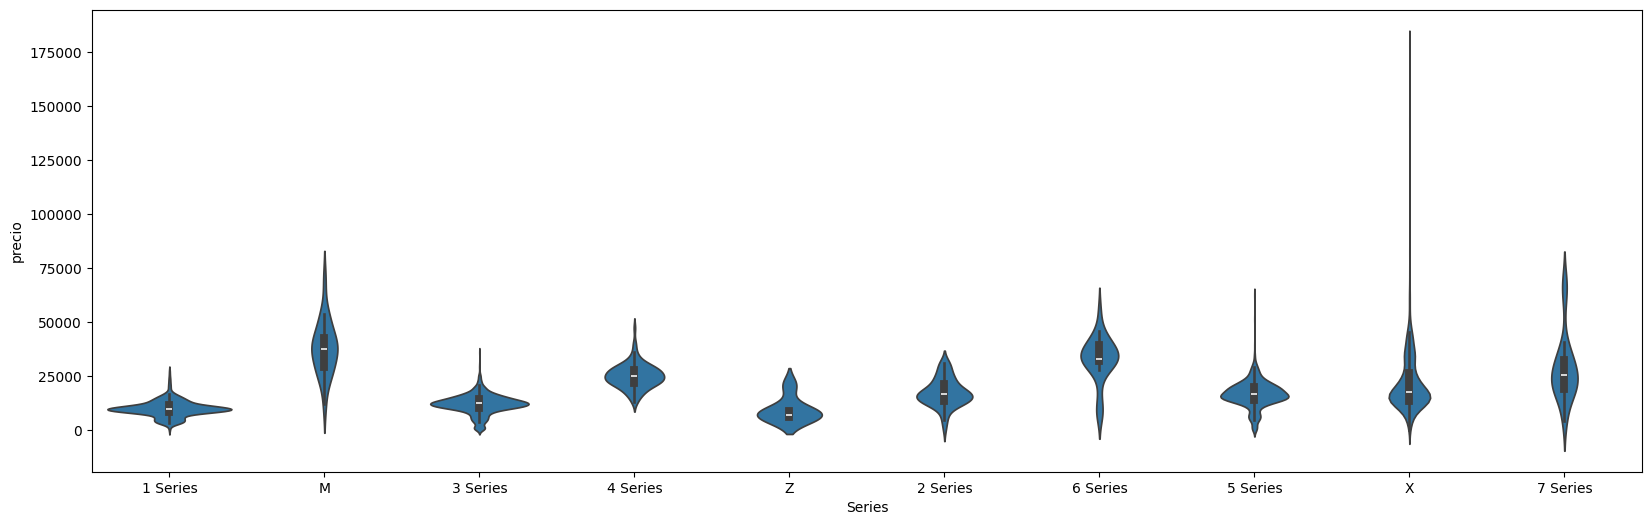

In [106]:
plt.figure(figsize=(20, 6))
sns.violinplot(x=df5['Series'], y=df5['precio'])

##4. Análisis de correlación inicial
* El GPS se relaciona con otras variables pero no con el precio.
* La potencia está relacionada con alerta_lim_velocidad, bluetooth y aire_acondicionado, además de con el target.
* Los km con el target (inversamente) y poco con gps.
* Las fechas no muestran info en esta primera correlación. Las fechas de venta se borran.
* La columna 'is_petrol' derivada del tipo de combustible tiene apenas un 0.031 de correlación con el precio.

In [107]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4808 entries, 0 to 4842
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   modelo                          4808 non-null   object 
 1   km                              4808 non-null   float64
 2   potencia                        4808 non-null   float64
 3   color                           4808 non-null   object 
 4   tipo_coche                      4808 non-null   object 
 5   volante_regulable               4808 non-null   bool   
 6   aire_acondicionado              4808 non-null   bool   
 7   camara_trasera                  4808 non-null   bool   
 8   elevalunas_electrico            4808 non-null   bool   
 9   bluetooth                       4808 non-null   bool   
 10  gps                             4808 non-null   bool   
 11  alerta_lim_velocidad            4808 non-null   bool   
 12  precio                          4808 no

In [108]:
corr = df5.corr(numeric_only = True)

In [109]:
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,fecha_venta_month,fecha_venta_year,is_petrol,is_gran
km,1.000000,-0.047444,0.067549,0.008392,0.003616,0.049433,-0.030989,0.157013,-0.025580,-0.411441,0.015536,0.014188,-0.011154,0.007100,0.017636,0.007100,-0.014400,-0.017634,-0.001677,nan,-0.037481,-0.064039
potencia,-0.047444,1.000000,0.326038,0.155409,0.316453,0.341319,0.204185,0.006946,0.425792,0.645023,0.001908,0.025407,-0.011807,-0.016590,-0.018758,-0.016590,0.017685,0.018646,-0.028822,nan,0.121549,0.035200
volante_regulable,0.067549,0.326038,1.000000,0.261212,0.253979,0.279054,0.125291,0.245093,0.186154,0.268341,-0.019796,0.003346,-0.001860,0.000500,0.002033,0.000500,-0.016187,-0.001701,0.080347,nan,-0.010519,0.020405
aire_acondicionado,0.008392,0.155409,0.261212,1.000000,0.104024,0.232216,0.090621,0.300396,0.162281,0.209265,-0.528977,0.018784,-0.012549,-0.017584,-0.021984,-0.017584,0.016123,0.021951,-0.010562,nan,-0.084266,0.045332
camara_trasera,0.003616,0.316453,0.253979,0.104024,1.000000,0.199071,0.126267,0.061582,0.166792,0.257794,0.029478,0.026526,-0.005096,-0.000101,0.000501,-0.000101,0.007392,-0.000474,0.021037,nan,0.014616,0.047424
elevalunas_electrico,0.049433,0.341319,0.279054,0.232216,0.199071,1.000000,0.231873,0.203373,0.291540,0.268423,-0.014868,0.013740,0.001438,-0.001734,-0.003879,-0.001734,0.011462,0.003760,-0.023258,nan,0.006341,0.056345
bluetooth,-0.030989,0.204185,0.125291,0.090621,0.126267,0.231873,1.000000,0.115085,0.088398,0.188709,-0.003499,-0.214226,-0.019675,-0.005749,-0.007314,-0.005749,0.009910,0.007249,-0.012899,nan,0.030738,0.065301
gps,0.157013,0.006946,0.245093,0.300396,0.061582,0.203373,0.115085,1.000000,-0.067849,-0.000737,-0.006295,0.011955,0.021054,-0.017573,-0.015642,-0.017573,0.002071,0.015892,0.062783,nan,-0.046568,0.023051
alerta_lim_velocidad,-0.025580,0.425792,0.186154,0.162281,0.166792,0.291540,0.088398,-0.067849,1.000000,0.381982,-0.007219,0.029200,-0.389489,-0.006321,-0.009268,-0.006321,0.004521,0.009160,-0.037697,nan,-0.021851,0.064336
precio,-0.411441,0.645023,0.268341,0.209265,0.257794,0.268423,0.188709,-0.000737,0.381982,1.000000,-0.022889,0.026343,-0.006480,-0.023368,-0.033271,-0.023368,0.014446,0.033375,0.016173,nan,-0.031127,0.113601


In [110]:
#Al no haber correlación entre fechas de venta y otras variables se decide borrarlas (su info sigue en la columna 'meses_registro_a_venta')
df5.drop(['fecha_venta_month','fecha_venta_year'],axis=1,inplace=True)

##5. Análisis variable vs target

###5.1. Análisis target y creación de columna LOG_precio

In [111]:
target = "precio"

In [112]:
df6 = df5.copy()

<Axes: >

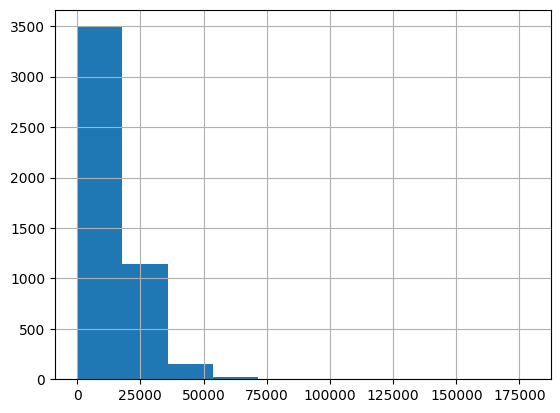

In [113]:
df6[target].hist()

In [114]:
df6['LOG_precio']=np.log10(df6['precio'])

<Axes: >

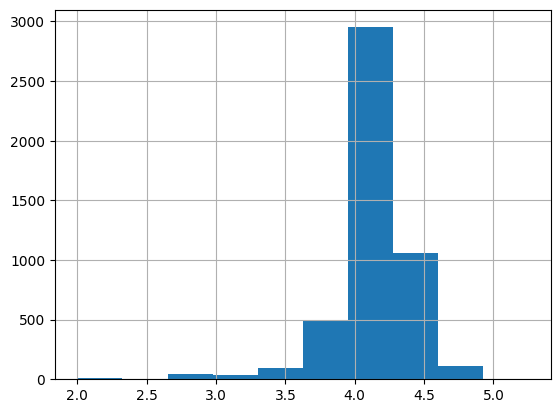

In [115]:
df6['LOG_precio'].hist()

<Axes: xlabel='precio'>

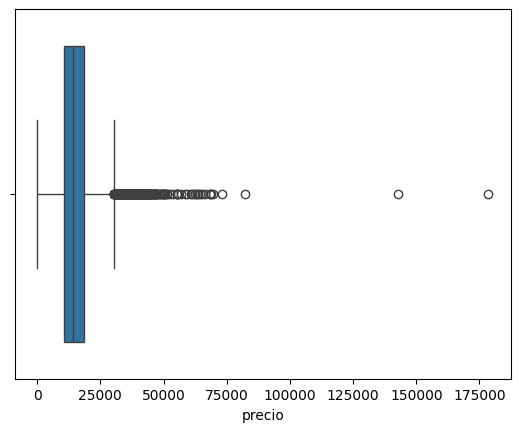

In [116]:
sns.boxplot(x=df6['precio'])

In [117]:
pd.set_option('display.max_columns', None)

In [118]:
df6.loc[df6['precio']>90000] # Aquí observamos los outliers, podemos borrar las filas con precio superior a 90000

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,is_petrol,Series,is_gran,X_Model,LOG_precio
4684,X4,103222.0,140.0,grey,suv,True,True,False,True,False,True,True,142800.0,False,False,False,False,48,False,8,2014,False,X,False,X4,5.154728
4753,X3,72515.0,135.0,blue,suv,False,False,True,False,False,False,True,178500.0,False,True,False,False,65,False,3,2013,False,X,False,X3,5.251638


In [119]:
#La fila del X4 de 103222km es outlier, tiene un valor 5 veces superior a de los demás coches en su modelo y km parecidos
df6.loc[(df6['modelo']=="X4")&(df6['km']>80000)&(df6['potencia']==140)]

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,is_petrol,Series,is_gran,X_Model,LOG_precio
3891,X4,95351.0,140.0,grey,Otro_tipo,True,True,True,False,True,False,True,28600.0,False,False,False,False,39,False,11,2014,False,X,False,X4,4.456366
3903,X4,87161.0,140.0,black,suv,True,True,False,False,False,False,True,28200.0,False,False,False,True,1418,True,1,1900,False,X,False,X4,4.450249
4042,X4,121365.0,140.0,black,Otro_tipo,True,True,False,True,False,True,True,31500.0,False,False,False,True,1418,True,1,1900,False,X,False,X4,4.498311
4135,X4,182721.0,140.0,grey,Otro_tipo,True,True,False,True,False,True,True,19400.0,False,True,False,True,1419,True,1,1900,False,X,False,X4,4.287802
4142,X4,103064.0,140.0,Other_color,Otro_tipo,True,True,False,False,False,True,True,30500.0,False,False,False,False,41,False,1,2015,False,X,False,X4,4.484300
4313,X4,185936.0,140.0,red,suv,True,True,False,True,False,True,True,30300.0,False,False,False,False,40,False,1,2015,False,X,False,X4,4.481443
4342,X4,90853.0,140.0,silver,suv,True,True,False,True,False,True,True,32200.0,False,False,False,True,1420,True,1,1900,False,X,False,X4,4.507856
4366,X4,136235.0,140.0,red,suv,True,True,False,False,True,True,True,32100.0,False,False,False,True,1421,True,1,1900,False,X,False,X4,4.506505
4684,X4,103222.0,140.0,grey,suv,True,True,False,True,False,True,True,142800.0,False,False,False,False,48,False,8,2014,False,X,False,X4,5.154728
4774,X4,80510.0,140.0,silver,suv,True,True,False,False,False,True,True,19000.0,False,False,False,False,37,False,8,2015,False,X,False,X4,4.278754


In [120]:
#la fila del X3 de 72515km es outlier, con un valor 9 veces superior a los coches de su modelo y km parecidos
df6.loc[(df6['modelo']=="X3")&(df6['km']<80000)&(df6['potencia']==135)]

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,is_petrol,Series,is_gran,X_Model,LOG_precio
3755,X3,73086.0,135.0,black,Otro_tipo,False,False,False,False,False,False,True,17500.0,False,False,False,True,1424,True,1,1900,False,X,False,X3,4.243038
3782,X3,67967.0,135.0,grey,suv,False,False,False,False,False,False,False,18200.0,False,False,False,True,1419,True,1,1900,False,X,False,X3,4.260071
3787,X3,57435.0,135.0,Other_color,Otro_tipo,False,False,False,False,False,False,False,26700.0,False,False,True,True,1422,True,1,1900,False,X,False,X3,4.426511
3852,X3,61969.0,135.0,black,Otro_tipo,False,False,False,False,False,False,True,25100.0,False,False,False,True,1416,True,1,1900,False,X,False,X3,4.399674
3873,X3,77851.0,135.0,white,suv,False,False,False,False,False,False,False,15900.0,False,False,False,True,1417,True,1,1900,False,X,False,X3,4.201397
3884,X3,44553.0,135.0,black,suv,True,True,False,False,False,False,True,12000.0,False,False,False,True,1417,True,1,1900,False,X,False,X3,4.079181
4003,X3,24175.0,135.0,beige,suv,True,True,False,True,False,True,True,22600.0,False,True,False,True,1418,True,1,1900,False,X,False,X3,4.354108
4064,X3,54612.0,135.0,black,Otro_tipo,True,True,False,True,True,True,True,24100.0,False,False,False,False,46,False,5,2014,False,X,False,X3,4.382017
4098,X3,69362.0,135.0,grey,suv,True,True,False,True,True,True,True,23600.0,False,False,False,False,54,False,9,2013,False,X,False,X3,4.372912
4168,X3,63507.0,135.0,grey,suv,False,False,False,False,False,False,True,22600.0,False,False,False,False,56,False,8,2013,False,X,False,X3,4.354108


In [121]:
#Eliminamos los outliers de precio una vez comprobado que con alta probabilidad los precios son incorrectos
df6.drop(df6.loc[df6['precio']>90000].index, axis=0, inplace = True)

In [122]:
df6.loc[df6['precio']>90000]

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,is_petrol,Series,is_gran,X_Model,LOG_precio


In [123]:
#En lo referido a precios menores a 400€, se decide dejarlos ya que podrían ser coches con daños, piezas con cambio imperativo etc
df6.loc[df6['precio']<400]

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,meses_registro_a_venta,meses_registro_a_venta_missing,fecha_registro_month,fecha_registro_year,is_petrol,Series,is_gran,X_Model,LOG_precio
565,320,179358.0,120.0,black,Otro_tipo,False,True,False,False,False,True,True,100.0,False,False,False,False,57,False,6,2013,False,3 Series,False,NULL,2.00000
630,318,147558.0,105.0,white,estate,False,False,False,False,False,False,True,100.0,True,False,False,False,40,False,11,2014,False,3 Series,False,NULL,2.00000
879,318,134156.0,105.0,grey,estate,False,True,False,False,False,False,True,100.0,False,False,False,False,46,False,6,2014,False,3 Series,False,NULL,2.00000
1255,320,170381.0,135.0,silver,Otro_tipo,True,True,False,False,False,True,False,100.0,False,False,False,True,1420,True,1,1900,False,3 Series,False,NULL,2.00000
1832,116,174524.0,85.0,blue,hatchback,False,True,False,False,False,True,False,100.0,False,False,True,False,44,False,7,2014,False,1 Series,False,NULL,2.00000
2473,525,230578.0,85.0,Other_color,sedan,False,False,False,False,False,True,False,200.0,True,False,True,False,253,False,7,1997,False,5 Series,False,NULL,2.30103
2574,525,229880.0,85.0,black,sedan,False,False,False,False,False,True,False,200.0,True,True,False,False,253,False,7,1997,False,5 Series,False,NULL,2.30103
2611,525,230264.0,85.0,black,sedan,False,False,False,False,False,True,False,200.0,False,False,False,False,253,False,7,1997,False,5 Series,False,NULL,2.30103
2829,525,439060.0,105.0,silver,Otro_tipo,False,False,True,False,False,True,False,100.0,False,False,False,True,1418,True,1,1900,False,5 Series,False,NULL,2.00000
4356,X3,79685.0,190.0,black,suv,False,False,False,False,False,False,False,100.0,False,False,True,False,51,False,2,2014,False,X,False,X3,2.00000


###5.2. Relación de target con las variables numéricas:

In [124]:
for i in df6:
  if (df6[i].dtype.kind == 'i') | (df6[i].dtype.kind == 'f'):
    print(i)

km
potencia
precio
meses_registro_a_venta
fecha_registro_month
fecha_registro_year
LOG_precio


In [125]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4806 entries, 0 to 4842
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   modelo                          4806 non-null   object 
 1   km                              4806 non-null   float64
 2   potencia                        4806 non-null   float64
 3   color                           4806 non-null   object 
 4   tipo_coche                      4806 non-null   object 
 5   volante_regulable               4806 non-null   bool   
 6   aire_acondicionado              4806 non-null   bool   
 7   camara_trasera                  4806 non-null   bool   
 8   elevalunas_electrico            4806 non-null   bool   
 9   bluetooth                       4806 non-null   bool   
 10  gps                             4806 non-null   bool   
 11  alerta_lim_velocidad            4806 non-null   bool   
 12  precio                          4806 no

####km está inversamente relacionado con el target

<Axes: xlabel='km', ylabel='precio'>

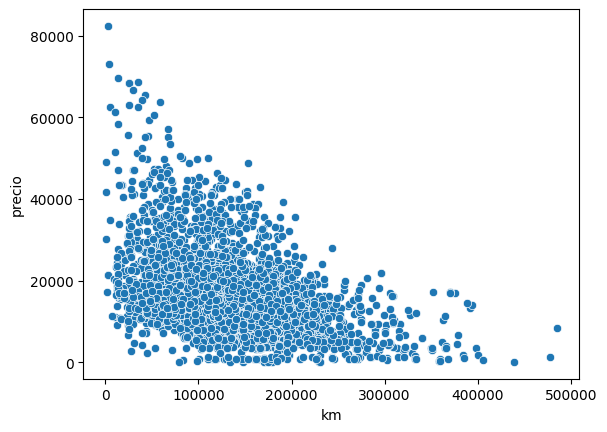

In [126]:
sns.scatterplot(x=df6['km'], y=df6["precio"])

####La potencia está relacionada directamente con el precio

<Axes: xlabel='potencia', ylabel='precio'>

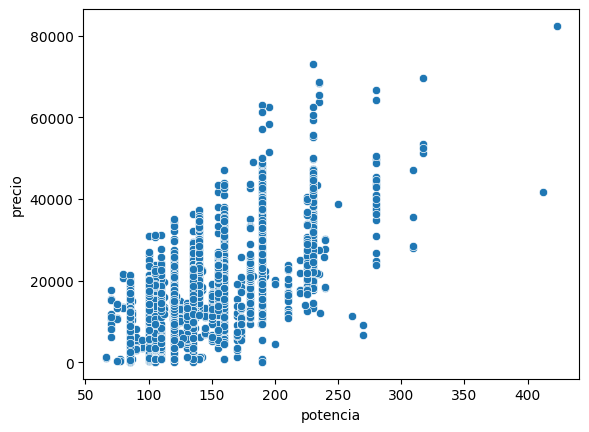

In [127]:
sns.scatterplot(x=df6['potencia'], y=df6["precio"])

####Mediante los valores no nulos de meses_registro_a_venta está inversamente relacionada con el precio
Cuantos menos meses hayan transcurrido entre registro y venta, más caro es el coche. Aunque se podría inducir que cuanto más nuevo es el coche más caro es, no podemos concluir por la fecha de registro que el coche se ha fabricado en ese año.

<Axes: xlabel='meses_registro_a_venta', ylabel='precio'>

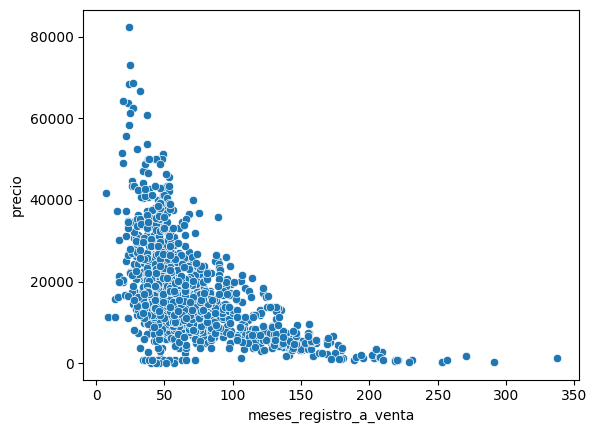

In [128]:
sns.scatterplot(x=df6.loc[df6['meses_registro_a_venta_missing']==0,'meses_registro_a_venta'], y=df6["precio"])

####La fecha_registro_year está relacionada directamente con el precio, cuanto más nuevo más vale

<Axes: xlabel='fecha_registro_year', ylabel='precio'>

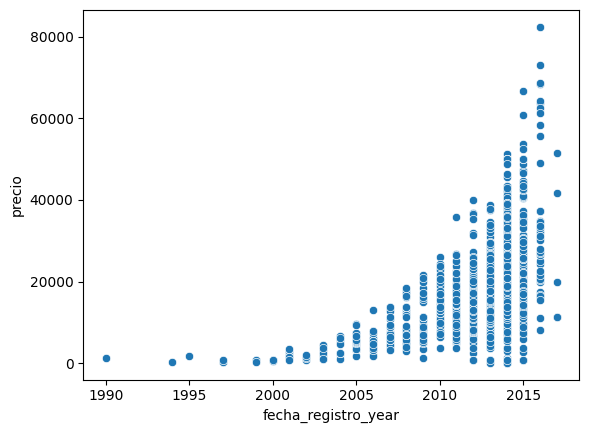

In [129]:
sns.scatterplot(x=df6.loc[df6['fecha_registro_missing']==0,'fecha_registro_year'], y=df6["precio"])

In [130]:
reg_no_miss = (df6['fecha_registro_missing']==0)
reg_corr = df6.loc[reg_no_miss,['fecha_registro_year',target]].corr()
diff_corr = df6.loc[reg_no_miss,['meses_registro_a_venta',target]].corr()
diff_reg_corr = df6.loc[reg_no_miss,['meses_registro_a_venta','fecha_registro_year']].corr()

print("La correlación fecha_registro_year con target es: ", reg_corr)
print("La correlación meses_registro_a_venta con target es: ", diff_corr)
print("La correlación meses_registro_a_venta con fecha_registro_year es: ", diff_reg_corr)

La correlación fecha_registro_year con target es:                       fecha_registro_year    precio
fecha_registro_year             1.000000  0.469695
precio                          0.469695  1.000000
La correlación meses_registro_a_venta con target es:                          meses_registro_a_venta    precio
meses_registro_a_venta                1.000000 -0.466877
precio                               -0.466877  1.000000
La correlación meses_registro_a_venta con fecha_registro_year es:                          meses_registro_a_venta  fecha_registro_year
meses_registro_a_venta                1.000000            -0.991054
fecha_registro_year                  -0.991054             1.000000


In [131]:
#Dada la mayor correlación entre fecha_registro_year y target que la de la columna 'meses_registro_a_venta',
#decidimos borrar las columnas calculadas ya que no aportan información adicional respecto al target
df6.drop(['meses_registro_a_venta','meses_registro_a_venta_missing','fecha_registro_month'],axis=1,inplace=True)

###5.3. Relación de target con las variables categóricas y booleanas:

####Cada Series tiene rangos de precio diferentes

In [132]:
df6.groupby('Series')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
Series,,,,,,,,
1 Series,563.0,10026.465364,3618.107797,100.0,8300.0,9900.0,11700.0,27400.0
2 Series,53.0,17481.132075,6441.065864,800.0,13600.0,16900.0,21400.0,31000.0
3 Series,1787.0,12154.896475,4424.315933,100.0,10200.0,12400.0,14600.0,36000.0
4 Series,102.0,25118.627451,5627.896049,13100.0,21725.0,24950.0,28100.0,47300.0
5 Series,1135.0,16773.303965,6063.972679,100.0,13950.0,16700.0,20100.0,62500.0
6 Series,29.0,32817.241379,10509.385906,6800.0,32000.0,33100.0,39300.0,55200.0
7 Series,54.0,28575.925926,15528.913206,4500.0,19050.0,25350.0,32675.0,68700.0
M,22.0,38122.727273,12314.642149,12100.0,29175.0,37550.0,42650.0,69700.0
X,1055.0,21150.616114,11319.803351,100.0,13700.0,17600.0,26500.0,82400.0


####Color: no se aprecian diferencias notables

In [133]:
df6.groupby('color')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
color,,,,,,,,
Other_color,442.0,15511.538462,8445.392302,200.0,10425.0,13750.0,19475.0,50600.0
beige,37.0,14916.216216,4747.544015,7700.0,12100.0,13600.0,16700.0,28600.0
black,1485.0,16166.801347,8783.218550,100.0,11000.0,14600.0,19200.0,68300.0
blue,640.0,14921.562500,8254.301524,100.0,10100.0,13350.0,17600.0,51200.0
brown,301.0,15527.242525,7122.933996,3200.0,11200.0,13900.0,17700.0,46500.0
green,14.0,6935.714286,5339.923241,700.0,2250.0,7000.0,8850.0,20500.0
grey,1062.0,15372.504708,8424.236675,100.0,10800.0,14000.0,17600.0,69700.0
orange,6.0,18866.666667,6261.203292,13100.0,13775.0,17400.0,22675.0,28300.0
red,47.0,16642.553191,12014.515581,2600.0,11200.0,13400.0,17600.0,82400.0


####is_petrol: los coches de gasolina pueden resultar algo más baratos, pero disponemos de muy pocos datos (<4%)

In [134]:
df6.groupby('is_petrol')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
is_petrol,,,,,,,,
False,4615.0,15784.680390,8397.721517,100.0,10900.0,14300.0,18600.0,73100.0
True,191.0,14398.429319,12374.619511,400.0,6100.0,11900.0,18900.0,82400.0


####tipo_coche: se aprecian precios medios diferentes según el tipo de coche

También podrían estar relacionados con la columna Series, pero salvo en el tipo SUV, no se aprecia una relación directa entre columnas (un tipo perteneciendo a una Serie o viceversa)

In [135]:
df6.groupby('tipo_coche')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
tipo_coche,,,,,,,,
Otro_tipo,1445.0,15590.519031,8245.050564,100.0,10800.0,14200.0,18600.0,65400.0
convertible,29.0,16831.034483,13922.286949,1800.0,8000.0,11800.0,24200.0,69700.0
coupe,72.0,21465.277778,10602.765514,1000.0,11200.0,23050.0,28000.0,55200.0
estate,1101.0,13042.779292,5411.178253,100.0,10100.0,13000.0,15700.0,40900.0
hatchback,485.0,13239.381443,6236.326831,100.0,9300.0,11900.0,16100.0,40500.0
sedan,819.0,16008.791209,8166.530531,200.0,12000.0,14900.0,18850.0,68700.0
subcompact,77.0,9732.467532,3805.413096,1400.0,8200.0,9300.0,11400.0,21700.0
suv,750.0,21310.133333,11349.740649,100.0,13800.0,17800.0,26500.0,82400.0
van,28.0,14646.428571,4216.412565,4800.0,12450.0,14100.0,17275.0,22700.0


In [136]:
df6.loc[df6['tipo_coche']!='No_tipo'].groupby('Series')['tipo_coche'].describe()

,count,unique,top,freq
Series,,,,
1 Series,563,7,hatchback,301
2 Series,53,4,van,26
3 Series,1787,8,estate,682
4 Series,102,5,coupe,33
5 Series,1135,5,estate,413
6 Series,29,5,coupe,10
7 Series,54,3,sedan,35
M,22,5,Otro_tipo,8
X,1055,4,suv,749


In [137]:
df6.loc[df6['tipo_coche']!='No_tipo'].groupby('tipo_coche')['Series'].describe()

,count,unique,top,freq
tipo_coche,,,,
Otro_tipo,1445,10,3 Series,548
convertible,29,7,3 Series,8
coupe,72,6,4 Series,33
estate,1101,5,3 Series,682
hatchback,485,6,1 Series,301
sedan,819,7,3 Series,408
subcompact,77,2,1 Series,75
suv,750,2,X,749
van,28,3,2 Series,26


####volante_regulable está directamente relacionado con el target

<Axes: xlabel='volante_regulable', ylabel='precio'>

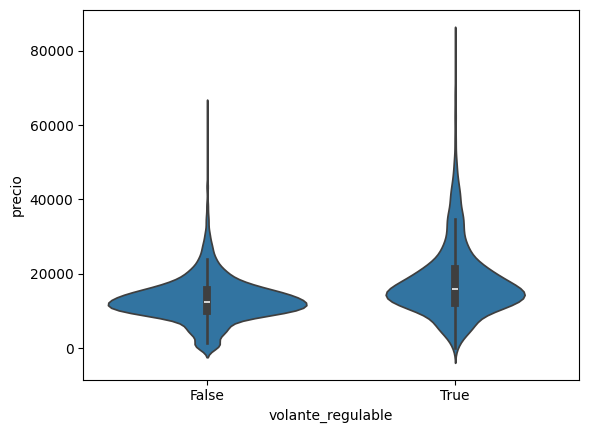

In [138]:
sns.violinplot(x=df6['volante_regulable'], y=df6['precio'])

In [139]:
df6.groupby('volante_regulable')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
volante_regulable,,,,,,,,
False,2166.0,13020.083102,5895.525229,100.0,9900.0,12500.0,15600.0,64300.0
True,2640.0,17952.613636,9745.477901,100.0,12100.0,15800.0,21200.0,82400.0


####camara_trasera está directamente relacionado con el target

In [140]:
df6.groupby('camara_trasera')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
camara_trasera,,,,,,,,
False,3838.0,14578.895258,7415.342211,100.0,10500.0,13400.0,17300.0,73100.0
True,968.0,20291.942149,11075.443884,100.0,13400.0,17400.0,24500.0,82400.0


####elevalunas_electrico está directamente relacionado con el target

<Axes: xlabel='elevalunas_electrico', ylabel='precio'>

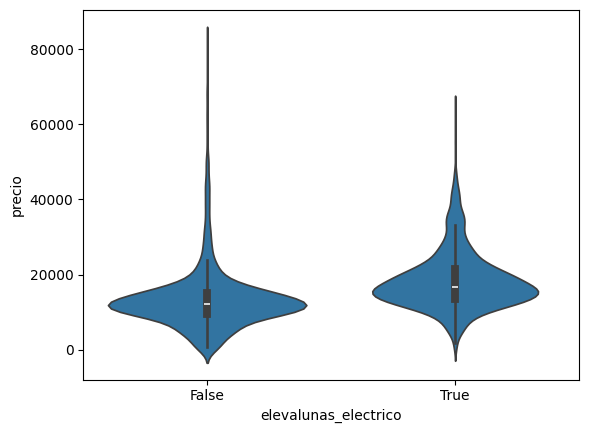

In [141]:
sns.violinplot(x=df6['elevalunas_electrico'], y=df6['precio'])

In [142]:
df6.groupby('elevalunas_electrico')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
elevalunas_electrico,,,,,,,,
False,2591.0,13469.625627,8618.380276,100.0,9400.0,12100.0,15200.0,82400.0
True,2215.0,18373.182844,7772.320978,400.0,13400.0,16800.0,21400.0,64300.0


####gps no tiene relación aparente con el target

<Axes: xlabel='gps', ylabel='precio'>

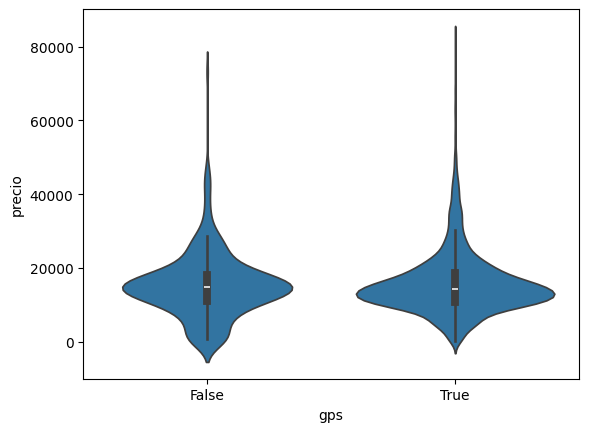

In [143]:
sns.violinplot(x=df6['gps'], y=df6['precio'])

In [144]:
df6.groupby('gps')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
gps,,,,,,,,
False,326.0,15315.644172,8832.156321,100.0,11125.0,14850.0,18200.0,73100.0
True,4480.0,15759.709821,8576.025369,100.0,10800.0,14200.0,18600.0,82400.0


###5.4. Relación de target con las variables con columna 'missing':

In [145]:
#Comprobación de la correlación entre columnas '_missing'. No se aprecia ninguna relación entre ellas
df6[[c for c in df6.columns if c.endswith('_missing')]].corr()


,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing
aire_acondicionado_missing,1.000000,-0.000505,-0.008267,-0.013034
bluetooth_missing,-0.000505,1.000000,0.002501,-0.009143
alerta_lim_velocidad_missing,-0.008267,0.002501,1.000000,-0.020790
fecha_registro_missing,-0.013034,-0.009143,-0.020790,1.000000


####aire_acondicionado,  está relacionado directamente con el precio
Se revisan los datos teniendo en cuenta la columna que nos indica los datos reales de la columna y a parte los datos de los 'missing'

In [146]:
df6.loc[df6['aire_acondicionado_missing']==0].groupby('aire_acondicionado')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
aire_acondicionado,,,,,,,,
False,885.0,11282.485876,6519.105105,100.0,7400.0,10700.0,14500.0,44300.0
True,3440.0,16952.529070,8672.442812,100.0,11800.0,15000.0,19600.0,69700.0


In [147]:
df6.loc[df6['aire_acondicionado_missing']==1].groupby('aire_acondicionado')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
aire_acondicionado,,,,,,,,
False,481.0,15165.696466,8637.860459,100.0,10400.0,13900.0,17800.0,82400.0


####bluetooth: está relacionado directamente con el precio

In [148]:
df6.loc[df6['bluetooth_missing']!=1].groupby('bluetooth')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
bluetooth,,,,,,,,
False,3094.0,14537.653523,7780.368228,100.0,10225.0,13400.0,17100.0,82400.0
True,990.0,19159.292929,9733.700410,700.0,12925.0,16800.0,22600.0,69700.0


In [149]:
df6.loc[df6['bluetooth_missing']!=0].groupby('bluetooth')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
bluetooth,,,,,,,,
False,722.0,16134.626039,8948.959473,200.0,10900.0,14500.0,19200.0,68300.0


####alerta_lim_velocidad: está relacionado directamente con el precio

In [150]:
df6.loc[df6['alerta_lim_velocidad_missing']!=1].groupby('alerta_lim_velocidad')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
alerta_lim_velocidad,,,,,,,,
False,1865.0,11380.375335,4738.102433,100.0,9000.0,11400.0,14000.0,64300.0
True,2219.0,19410.950879,9401.844587,100.0,13800.0,17300.0,22400.0,82400.0


In [151]:
df6.loc[df6['alerta_lim_velocidad_missing']!=0].groupby('alerta_lim_velocidad')['precio'].describe()

,count,mean,std,min,25%,50%,75%,max
alerta_lim_velocidad,,,,,,,,
False,722.0,15649.722992,8457.612755,100.0,10800.0,13800.0,18400.0,65400.0


##6. Variables categóricas a numéricas mediante OHE
Nos disponemos a convertir las columnas 'color', 'tipo_coche', 'Series' y 'X_Model'. La columna modelo es eliminada.

In [181]:
df7 = df6.copy()

In [182]:
target = ['precio', 'LOG_precio']

In [183]:
del(df7['modelo'])

In [184]:
def obtener_lista_variables(dataset):

    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset:
        if    (dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())!= 2 and i not in target:
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind in ("f","i","b")) and len(dataset[i].unique())== 2 and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind == "O") and i not in target:
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

In [185]:
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(df7)

In [174]:
lista_numericas

['km', 'potencia', 'fecha_registro_year']

In [175]:
lista_boolean

['volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'elevalunas_electrico',
 'bluetooth',
 'gps',
 'alerta_lim_velocidad',
 'aire_acondicionado_missing',
 'bluetooth_missing',
 'alerta_lim_velocidad_missing',
 'fecha_registro_missing',
 'is_petrol',
 'is_gran']

In [186]:
lista_categoricas

['color', 'tipo_coche', 'Series', 'X_Model']

####Función ohe_variables_2percent
Para limitar la cantidad de columnas que se crearán en el OHE, agrupamos mediante la siguiente función las categorías que tienen menos del 2% de filas respecto del total. Son agrupadas en la variable 'selected_category' que puede ser una que ya exista o una nueva que agrupe

Con el objetivo de asegurar un correcto funcionamiento se imprime con la ejecución la lista de variables con menos de 2% de valores

In [187]:
def ohe_variables_2percent(series, selected_category):
  vc = series.value_counts()
  remove_list=[]
  for key in vc.keys():
    if vc.loc[key]<series.count()*0.02:
      remove_list.append(key)
  print(remove_list)
  # Replace categories in remove_list with the selected_category
  modified_series = series.replace(remove_list, selected_category)
  return modified_series

###6.1. 'Color'
Agruparemos los colores minoritarios en 'Other_colors'

In [188]:
df7['color'].value_counts()

,count
color,
black,1485
grey,1062
blue,640
white,482
Other_color,442
brown,301
silver,290
red,47
beige,37


In [189]:
df7['color'] = ohe_variables_2percent(df7['color'], 'Other_color')

['red', 'beige', 'green', 'orange']


###6.2. 'tipo_coche'
Agruparemos los tipo_coche minoritarios en 'Otro_tipo'

In [190]:
df7['tipo_coche'] = ohe_variables_2percent(df7['tipo_coche'], 'Otro_tipo')

['subcompact', 'coupe', 'convertible', 'van']


In [191]:
df7['tipo_coche'].value_counts()

,count
tipo_coche,
Otro_tipo,1651
estate,1101
sedan,819
suv,750
hatchback,485


###6.3. 'Series'
Agruparemos las Series minoritarias en 'Other_Series'

In [192]:
df7['Series'].value_counts()

,count
Series,
3 Series,1787
5 Series,1135
X,1055
1 Series,563
4 Series,102
7 Series,54
2 Series,53
6 Series,29
M,22


In [193]:
df7['Series'] = ohe_variables_2percent(df7['Series'], 'Other_Series')

['7 Series', '2 Series', '6 Series', 'M', 'Z']


In [194]:
df7['Series'].value_counts()

,count
Series,
3 Series,1787
5 Series,1135
X,1055
1 Series,563
Other_Series,164
4 Series,102


###6.4. 'X_Model'
Agruparemos los X_Model minoritarias en 'Other_X'

In [195]:
df7['X_Model'] = ohe_variables_2percent(df7['X_Model'], 'Other_X')

['X4', 'X6', 'X5 M', 'X6 M', 'X5 M50']


In [196]:
df7['X_Model'].value_counts()

,count
X_Model,
NULL,3751
X3,436
X1,274
X5,229
Other_X,116


###6.5. OHE mediante la funcion get_dummies

In [210]:
df_bmw_prep = pd.get_dummies(data=df7, columns=lista_categoricas, )

In [211]:
pd.set_option('display.max_columns', None)

In [212]:
df_bmw_prep.head(10)

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,fecha_registro_year,is_petrol,is_gran,LOG_precio,color_Other_color,color_black,color_blue,color_brown,color_grey,color_silver,color_white,tipo_coche_Otro_tipo,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_suv,Series_1 Series,Series_3 Series,Series_4 Series,Series_5 Series,Series_Other_Series,Series_X,X_Model_NULL,X_Model_Other_X,X_Model_X1,X_Model_X3,X_Model_X5
0,140411.0,100.0,True,True,False,True,False,True,False,11300.0,False,True,True,False,2012,False,False,4.053078,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1,13929.0,317.0,True,True,False,False,True,True,True,69700.0,False,False,False,True,1900,True,False,4.843233,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
2,183297.0,120.0,False,False,False,True,False,True,False,10200.0,False,False,False,False,2012,False,False,4.008600,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
3,128035.0,135.0,True,True,False,True,True,True,False,25100.0,False,False,True,True,1900,False,False,4.399674,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
4,97097.0,160.0,True,True,False,False,True,True,True,33400.0,False,False,False,True,1900,False,False,4.523746,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
5,152352.0,225.0,True,True,False,True,True,True,True,17100.0,False,False,False,False,2011,True,False,4.232996,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
6,205219.0,145.0,True,True,False,True,True,True,True,12400.0,False,False,False,True,1900,False,False,4.093422,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
7,115560.0,105.0,True,True,False,False,True,True,False,6100.0,False,False,False,False,2009,True,False,3.785330,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
8,123886.0,125.0,True,False,False,False,False,True,False,6200.0,False,True,False,True,1900,True,False,3.792392,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
9,139541.0,135.0,False,False,False,True,False,True,False,17300.0,False,False,False,True,1900,False,False,4.238046,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


In [238]:
pd.reset_option("display.max_columns")

In [213]:
df_bmw_prep.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4806 entries, 0 to 4842
Columns: 41 entries, km to X_Model_X5
dtypes: bool(36), float64(4), int32(1)
memory usage: 375.5 KB


##7. Escalado de variables numéricas mediante minmaxscaler y correlación final

In [214]:
lista_numericas

['km', 'potencia', 'fecha_registro_year']

In [215]:
MinMax = MinMaxScaler()

###7.1. 'fecha_registro_year' se trata a parte
Al tener la mitad de los años en 1900, perdería la información al estar todos los valores en 0 o cerca de 1. Con el objetivo de destacar los valores reales, se ha decidido escalar los valores reales y representar los valores nulos con 0.

In [217]:
lista_numericas.remove('fecha_registro_year')

In [223]:
mask = (df_bmw_prep['fecha_registro_missing'] == 0)
df_bmw_prep.loc[mask, 'fecha_registro_year'] = MinMax.fit_transform(df_bmw_prep.loc[mask, ['fecha_registro_year']])
# df.loc[mask, 'registry_year_scaled'] = scaler.fit_transform(
#     df.loc[mask, ['registry_year']]
# )


/tmp/ipython-input-3323192214.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.81481481 0.81481481 0.77777778 ... 0.92592593 0.92592593 0.96296296]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_bmw_prep.loc[mask, 'fecha_registro_year'] = MinMax.fit_transform(df_bmw_prep.loc[mask, ['fecha_registro_year']])


In [224]:
df_bmw_prep.loc[~mask, 'fecha_registro_year'] = 0

<Axes: >

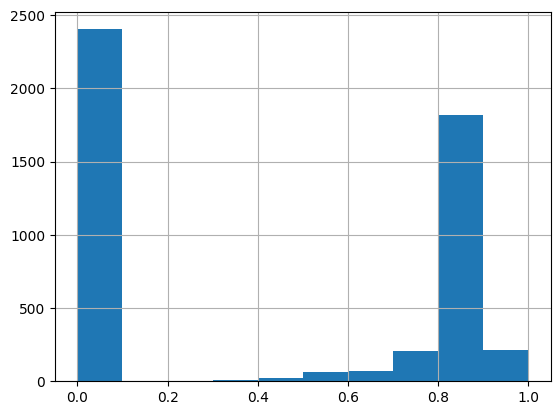

In [225]:
df_bmw_prep['fecha_registro_year'].hist()

###7.2. Tratado de km y potencia

In [226]:
df_bmw_prep[lista_numericas] = MinMax.fit_transform(df_bmw_prep[lista_numericas])

In [227]:
df_bmw_prep.head(10)

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,fecha_registro_year,is_petrol,is_gran,LOG_precio,color_Other_color,color_black,color_blue,color_brown,color_grey,color_silver,color_white,tipo_coche_Otro_tipo,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_suv,Series_1 Series,Series_3 Series,Series_4 Series,Series_5 Series,Series_Other_Series,Series_X,X_Model_NULL,X_Model_Other_X,X_Model_X1,X_Model_X3,X_Model_X5
0,0.289039,0.095238,True,True,False,True,False,True,False,11300.0,False,True,True,False,0.814815,False,False,4.053078,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1,0.027787,0.703081,True,True,False,False,True,True,True,69700.0,False,False,False,True,0.000000,True,False,4.843233,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
2,0.377621,0.151261,False,False,False,True,False,True,False,10200.0,False,False,False,False,0.814815,False,False,4.008600,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
3,0.263476,0.193277,True,True,False,True,True,True,False,25100.0,False,False,True,True,0.000000,False,False,4.399674,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
4,0.199573,0.263305,True,True,False,False,True,True,True,33400.0,False,False,False,True,0.000000,False,False,4.523746,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
5,0.313703,0.445378,True,True,False,True,True,True,True,17100.0,False,False,False,False,0.777778,True,False,4.232996,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
6,0.422901,0.221289,True,True,False,True,True,True,True,12400.0,False,False,False,True,0.000000,False,False,4.093422,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
7,0.237709,0.109244,True,True,False,False,True,True,False,6100.0,False,False,False,False,0.703704,True,False,3.785330,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
8,0.254906,0.165266,True,False,False,False,False,True,False,6200.0,False,True,False,True,0.000000,True,False,3.792392,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
9,0.287242,0.193277,False,False,False,True,False,True,False,17300.0,False,False,False,True,0.000000,False,False,4.238046,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False


###7.3. Correlación final

In [228]:
corr_final = df_bmw_prep.corr(numeric_only = True)

In [229]:
corr_final.style.background_gradient(cmap='coolwarm')

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,fecha_registro_year,is_petrol,is_gran,LOG_precio,color_Other_color,color_black,color_blue,color_brown,color_grey,color_silver,color_white,tipo_coche_Otro_tipo,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_suv,Series_1 Series,Series_3 Series,Series_4 Series,Series_5 Series,Series_Other_Series,Series_X,X_Model_NULL,X_Model_Other_X,X_Model_X1,X_Model_X3,X_Model_X5
km,1.000000,-0.047378,0.067429,0.008096,0.004034,0.049373,-0.031188,0.156407,-0.025186,-0.428978,0.015414,0.014718,-0.011314,0.006728,-0.058700,-0.037564,-0.064150,-0.432378,-0.005838,0.033783,-0.018947,-0.021240,0.028700,0.026420,-0.067823,-0.041039,0.137927,-0.097368,0.064379,-0.091901,-0.124033,0.110061,-0.142640,0.173463,-0.103207,-0.115196,0.115196,-0.104679,-0.060193,-0.034801,-0.035981
potencia,-0.047378,1.000000,0.326093,0.155472,0.316560,0.341361,0.204245,0.007060,0.425801,0.681181,0.001938,0.025371,-0.011769,-0.016502,0.026495,0.121570,0.035224,0.507642,-0.015785,0.034909,-0.014014,-0.056597,0.004518,0.013709,0.007371,-0.021754,-0.042428,-0.177771,0.027012,0.197163,-0.322379,-0.294417,0.056020,0.207296,0.285656,0.236728,-0.236728,0.252111,-0.118045,0.044880,0.346325
volante_regulable,0.067429,0.326093,1.000000,0.260864,0.254697,0.278756,0.125303,0.244595,0.186283,0.285625,-0.019814,0.003974,-0.001878,0.000459,-0.006403,-0.010530,0.020399,0.250926,-0.038118,0.025584,0.011618,0.039104,0.051030,-0.014578,-0.102698,-0.036912,0.003190,-0.117198,0.057960,0.081832,-0.242209,-0.203881,0.046337,0.270303,0.071206,0.101510,-0.101510,0.117929,-0.098316,0.056056,0.143714
aire_acondicionado,0.008096,0.155472,0.260864,1.000000,0.104825,0.231889,0.090552,0.299660,0.162584,0.225859,-0.529216,0.019641,-0.012637,-0.017792,0.039204,-0.084333,0.045295,0.283415,-0.046245,0.028032,0.002588,0.056266,0.020959,-0.037921,-0.041468,-0.057061,0.072378,-0.049237,0.046356,-0.016308,-0.170672,-0.032534,0.009574,0.169003,0.006641,-0.009071,0.009071,0.041993,-0.117626,0.003089,0.075986
camara_trasera,0.004034,0.316560,0.254697,0.104825,1.000000,0.199697,0.126487,0.063261,0.166571,0.266657,0.029595,0.025525,-0.004968,0.000209,-0.003050,0.014686,0.047526,0.198938,-0.042463,0.021219,-0.001383,-0.016329,0.016378,0.001285,0.003313,-0.007141,-0.036737,-0.032185,-0.012362,0.091407,-0.103888,-0.153433,-0.001959,0.098204,0.114217,0.109683,-0.109683,0.100183,-0.027271,0.018395,0.145827
elevalunas_electrico,0.049373,0.341361,0.278756,0.231889,0.199697,1.000000,0.231951,0.202934,0.291637,0.284464,-0.014861,0.014303,0.001452,-0.001702,0.011679,0.006349,0.056366,0.321146,-0.027152,0.079126,-0.035586,-0.021923,-0.016557,-0.032704,0.013694,-0.021023,0.045263,-0.070021,0.011699,0.021093,-0.188828,-0.158575,0.107131,0.248553,0.021648,0.030021,-0.030021,0.061299,-0.101324,0.017521,0.100834
bluetooth,-0.031188,0.204245,0.125303,0.090552,0.126487,0.231951,1.000000,0.114892,0.088653,0.203305,-0.003570,-0.214160,-0.019766,-0.005962,0.013338,0.030696,0.065251,0.184456,-0.010493,0.021268,0.007821,-0.046723,-0.031948,-0.016719,0.064591,0.000982,-0.016892,0.027489,-0.010547,0.006388,-0.014356,-0.020342,0.103480,-0.016719,0.031789,0.002086,-0.002086,0.037227,-0.076424,0.032580,0.016490
gps,0.156407,0.007060,0.244595,0.299660,0.063261,0.202934,0.114892,1.000000,-0.067191,0.012995,-0.006543,0.013837,0.020785,-0.018317,0.009843,-0.046780,0.022898,0.055756,-0.010336,0.049658,0.008311,0.035577,0.026002,-0.028943,-0.116536,-0.001759,0.054508,-0.000279,0.038633,-0.100612,0.023644,0.000369,-0.017689,0.087650,0.018799,-0.110825,0.110825,-0.011492,-0.122815,-0.076133,0.029263
alerta_lim_velocidad,-0.025186,0.425801,0.186283,0.162584,0.166571,0.291637,0.088653,-0.067191,1.000000,0.396797,-0.007071,0.028785,-0.389409,-0.005875,0.019809,-0.021766,0.064470,0.354260,-0.038268,0.046386,-0.011667

In [230]:
corr2 = corr_final.where(np.triu(np.ones(corr_final.shape),k=1).astype(bool)) # Nos quedamos con el triangulo superior

In [231]:
corr2

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,aire_acondicionado_missing,bluetooth_missing,alerta_lim_velocidad_missing,fecha_registro_missing,fecha_registro_year,is_petrol,is_gran,LOG_precio,color_Other_color,color_black,color_blue,color_brown,color_grey,color_silver,color_white,tipo_coche_Otro_tipo,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_suv,Series_1 Series,Series_3 Series,Series_4 Series,Series_5 Series,Series_Other_Series,Series_X,X_Model_NULL,X_Model_Other_X,X_Model_X1,X_Model_X3,X_Model_X5
km,NaN,-0.047378,0.067429,0.008096,0.004034,0.049373,-0.031188,0.156407,-0.025186,-0.428978,0.015414,0.014718,-0.011314,0.006728,-0.058700,-0.037564,-0.064150,-0.432378,-0.005838,0.033783,-0.018947,-0.021240,0.028700,0.026420,-0.067823,-0.041039,0.137927,-0.097368,0.064379,-0.091901,-0.124033,0.110061,-0.142640,0.173463,-0.103207,-0.115196,0.115196,-0.104679,-0.060193,-0.034801,-0.035981
potencia,NaN,NaN,0.326093,0.155472,0.316560,0.341361,0.204245,0.007060,0.425801,0.681181,0.001938,0.025371,-0.011769,-0.016502,0.026495,0.121570,0.035224,0.507642,-0.015785,0.034909,-0.014014,-0.056597,0.004518,0.013709,0.007371,-0.021754,-0.042428,-0.177771,0.027012,0.197163,-0.322379,-0.294417,0.056020,0.207296,0.285656,0.236728,-0.236728,0.252111,-0.118045,0.044880,0.346325
volante_regulable,NaN,NaN,NaN,0.260864,0.254697,0.278756,0.125303,0.244595,0.186283,0.285625,-0.019814,0.003974,-0.001878,0.000459,-0.006403,-0.010530,0.020399,0.250926,-0.038118,0.025584,0.011618,0.039104,0.051030,-0.014578,-0.102698,-0.036912,0.003190,-0.117198,0.057960,0.081832,-0.242209,-0.203881,0.046337,0.270303,0.071206,0.101510,-0.101510,0.117929,-0.098316,0.056056,0.143714
aire_acondicionado,NaN,NaN,NaN,NaN,0.104825,0.231889,0.090552,0.299660,0.162584,0.225859,-0.529216,0.019641,-0.012637,-0.017792,0.039204,-0.084333,0.045295,0.283415,-0.046245,0.028032,0.002588,0.056266,0.020959,-0.037921,-0.041468,-0.057061,0.072378,-0.049237,0.046356,-0.016308,-0.170672,-0.032534,0.009574,0.169003,0.006641,-0.009071,0.009071,0.041993,-0.117626,0.003089,0.075986
camara_trasera,NaN,NaN,NaN,NaN,NaN,0.199697,0.126487,0.063261,0.166571,0.266657,0.029595,0.025525,-0.004968,0.000209,-0.003050,0.014686,0.047526,0.198938,-0.042463,0.021219,-0.001383,-0.016329,0.016378,0.001285,0.003313,-0.007141,-0.036737,-0.032185,-0.012362,0.091407,-0.103888,-0.153433,-0.001959,0.098204,0.114217,0.109683,-0.109683,0.100183,-0.027271,0.018395,0.145827
elevalunas_electrico,NaN,NaN,NaN,NaN,NaN,NaN,0.231951,0.202934,0.291637,0.284464,-0.014861,0.014303,0.001452,-0.001702,0.011679,0.006349,0.056366,0.321146,-0.027152,0.079126,-0.035586,-0.021923,-0.016557,-0.032704,0.013694,-0.021023,0.045263,-0.070021,0.011699,0.021093,-0.188828,-0.158575,0.107131,0.248553,0.021648,0.030021,-0.030021,0.061299,-0.101324,0.017521,0.100834
bluetooth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.114892,0.088653,0.203305,-0.003570,-0.214160,-0.019766,-0.005962,0.013338,0.030696,0.065251,0.184456,-0.010493,0.021268,0.007821,-0.046723,-0.031948,-0.016719,0.064591,0.000982,-0.016892,0.027489,-0.010547,0.006388,-0.014356,-0.020342,0.103480,-0.016719,0.031789,0.002086,-0.002086,0.037227,-0.076424,0.032580,0.016490
gps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.067191,0.012995,-0.006543,0.013837,0.020785,-0.018317,0.009843,-0.046780,0.022898,0.055756,-0.010336,0.049658,0.008311,0.035577,0.026002,-0.028943,-0.116536,-0.001759,0.054508,-0.000279,0.038633,-0.100612,0.023644,0.000369,-0.017689,0.087650,0.018799,-0.110825,0.110825,-0.011492,-0.122815,-0.076133,0.029263
alerta_lim_velocidad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.396797,-0.007071,0.028785,-0.389409,-0.005875,0.019809,-0.021766,0.064470,0.354260,-0.038268,0.046386,-0.011667,-0.022352,-0.012414,-0.003325,0.020082,-0.023985,-0.002332,-0.125996,0.016491,0.121579,-0.268579,-0.164157,0.034475,0.213199,0.076507,0.136016,-0.136016,0.115419,-0.054919,0.062040,0.157267
precio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [232]:
corr3 = corr2.unstack().dropna()

In [233]:
corr3

potencia            km                -0.047378
volante_regulable   km                 0.067429
                    potencia           0.326093
aire_acondicionado  km                 0.008096
                    potencia           0.155472
                                         ...   
X_Model_X5          Series_X           0.421769
                    X_Model_NULL      -0.421769
                    X_Model_Other_X   -0.035178
                    X_Model_X1        -0.054999
                    X_Model_X3        -0.070653
Length: 820, dtype: float64

In [234]:
corr4 = corr3.sort_values()

In [235]:
pd.set_option('display.max_rows', None)

In [236]:
corr4

,,0
X_Model_NULL,Series_X,-1.000000
fecha_registro_year,fecha_registro_missing,-0.987910
X_Model_NULL,tipo_coche_suv,-0.809443
X_Model_X3,X_Model_NULL,-0.595593
aire_acondicionado_missing,aire_acondicionado,-0.529216
X_Model_X1,X_Model_NULL,-0.463637
LOG_precio,km,-0.432378
precio,km,-0.428978
Series_5 Series,Series_3 Series,-0.427796
X_Model_X5,X_Model_NULL,-0.421769


In [237]:
pd.reset_option("display.max_rows")

In [240]:
corr4.head(20)

,,0
X_Model_NULL,Series_X,-1.000000
fecha_registro_year,fecha_registro_missing,-0.987910
X_Model_NULL,tipo_coche_suv,-0.809443
X_Model_X3,X_Model_NULL,-0.595593
aire_acondicionado_missing,aire_acondicionado,-0.529216
X_Model_X1,X_Model_NULL,-0.463637
LOG_precio,km,-0.432378
precio,km,-0.428978
Series_5 Series,Series_3 Series,-0.427796
X_Model_X5,X_Model_NULL,-0.421769


In [239]:
corr4.tail(20)

elevalunas_electrico  potencia                0.341361
X_Model_X5            potencia                0.346325
                      tipo_coche_suv          0.350605
LOG_precio            alerta_lim_velocidad    0.354260
tipo_coche_hatchback  is_gran                 0.356810
X_Model_Other_X       precio                  0.360611
X_Model_X1            tipo_coche_suv          0.371511
X_Model_X5            precio                  0.382081
precio                alerta_lim_velocidad    0.396797
X_Model_NULL          Series_3 Series         0.408022
X_Model_X5            Series_X                0.421769
alerta_lim_velocidad  potencia                0.425801
X_Model_X1            Series_X                0.463637
X_Model_X3            tipo_coche_suv          0.483019
LOG_precio            potencia                0.507642
Series_1 Series       tipo_coche_hatchback    0.524503
X_Model_X3            Series_X                0.595593
precio                potencia                0.681181
Series_X              tipo_coche_suv          0.809443
LOG_precio            precio                  0.830619
dtype: float64

In [242]:
corr_long = (
    corr2
    .stack()
    .reset_index()
    .rename(columns={"level_0": "var_1", "level_1": "var_2", 0: "correlation"})
)


In [243]:
target_corr_long = corr_long[
    (corr_long["var_1"].isin(target)) ^ (corr_long["var_2"].isin(target))
].sort_values(by="correlation")


In [245]:
target_corr_long.head(10)

,var_1,var_2,correlation
16,km,LOG_precio,-0.432378
8,km,precio,-0.428978
350,precio,X_Model_NULL,-0.334590
345,precio,Series_3 Series,-0.320072
557,LOG_precio,Series_3 Series,-0.259548
562,LOG_precio,X_Model_NULL,-0.251695
344,precio,Series_1 Series,-0.241774
556,LOG_precio,Series_1 Series,-0.209484
340,precio,tipo_coche_estate,-0.170457
552,LOG_precio,tipo_coche_estate,-0.136028


In [246]:
target_corr_long.tail(10)

,var_1,var_2,correlation
193,elevalunas_electrico,precio,0.284464
85,volante_regulable,precio,0.285625
201,elevalunas_electrico,LOG_precio,0.321146
349,precio,Series_X,0.334590
300,alerta_lim_velocidad,LOG_precio,0.354260
351,precio,X_Model_Other_X,0.360611
354,precio,X_Model_X5,0.382081
292,alerta_lim_velocidad,precio,0.396797
55,potencia,LOG_precio,0.507642
47,potencia,precio,0.681181


In [250]:
target_corr_long.loc[(target_corr_long["var_1"] == "precio")^(target_corr_long["var_2"] == "precio")].tail(10).sort_values("correlation", ascending = False)

,var_1,var_2,correlation
47,potencia,precio,0.681181
292,alerta_lim_velocidad,precio,0.396797
354,precio,X_Model_X5,0.382081
351,precio,X_Model_Other_X,0.360611
349,precio,Series_X,0.334590
85,volante_regulable,precio,0.285625
193,elevalunas_electrico,precio,0.284464
343,precio,tipo_coche_suv,0.279278
158,camara_trasera,precio,0.266657
348,precio,Series_Other_Series,0.231735


In [249]:
target_corr_long.loc[(target_corr_long["var_1"] == "precio")^(target_corr_long["var_2"] == "precio")].head(10).sort_values("correlation")

,var_1,var_2,correlation
8,km,precio,-0.428978
350,precio,X_Model_NULL,-0.334590
345,precio,Series_3 Series,-0.320072
344,precio,Series_1 Series,-0.241774
340,precio,tipo_coche_estate,-0.170457
341,precio,tipo_coche_hatchback,-0.097094
352,precio,X_Model_X1,-0.086925
334,precio,color_blue,-0.036858
329,precio,is_petrol,-0.031517
337,precio,color_silver,-0.025280


In [251]:
target_corr_long.loc[(target_corr_long["var_1"] == "LOG_precio")^(target_corr_long["var_2"] == "LOG_precio")].tail(10).sort_values("correlation", ascending = False)

,var_1,var_2,correlation
55,potencia,LOG_precio,0.507642
300,alerta_lim_velocidad,LOG_precio,0.354260
201,elevalunas_electrico,LOG_precio,0.321146
130,aire_acondicionado,LOG_precio,0.283415
561,LOG_precio,Series_X,0.251695
93,volante_regulable,LOG_precio,0.250926
566,LOG_precio,X_Model_X5,0.245840
563,LOG_precio,X_Model_Other_X,0.222856
555,LOG_precio,tipo_coche_suv,0.207860
166,camara_trasera,LOG_precio,0.198938


In [252]:
target_corr_long.loc[(target_corr_long["var_1"] == "LOG_precio")^(target_corr_long["var_2"] == "LOG_precio")].head(10).sort_values("correlation")

,var_1,var_2,correlation
16,km,LOG_precio,-0.432378
557,LOG_precio,Series_3 Series,-0.259548
562,LOG_precio,X_Model_NULL,-0.251695
556,LOG_precio,Series_1 Series,-0.209484
552,LOG_precio,tipo_coche_estate,-0.136028
496,is_petrol,LOG_precio,-0.102137
553,LOG_precio,tipo_coche_hatchback,-0.069576
549,LOG_precio,color_silver,-0.056521
546,LOG_precio,color_blue,-0.049842
564,LOG_precio,X_Model_X1,-0.047664
